In [30]:
np.random.seed(23)
df = pd.read_csv('contraceptive_bangladeshi_1934.txt')

districts = df.sort_values(by="district").district.unique()
nb_districts = len(districts)

df.replace({'district': {61: 54}}, inplace=True)
# df.sort_values(by="district").district.unique()

sample_size = df.shape[0]

print(f'sample size = {sample_size}')

# simulate data
beta0_mu = 2
beta0_sigma = 1
beta0 = np.random.normal(beta0_mu, beta0_sigma, sample_size) 
beta1 = 4
beta2 = -3
beta3 = -2

df['contraceptive_use_sim'] = expit(beta0 + 
                                    beta1*df['urban'] + 
                                    beta2*df['living.children'] + 
                                    beta3*df['age_mean'])
df['contraceptive_use_sim'] = (df['contraceptive_use_sim']>.5).astype(int) 

print(f'df = \n{df.head()}')


sample size = 967
df = 
   district  urban  living.children  age_mean  contraceptive_use  \
0        35      0                4    2.4400                  0   
1        22      0                2   -1.5599                  1   
2        29      0                2   -8.5599                  1   
3         5      0                3   -4.5599                  1   
4        34      1                4    8.4400                  0   

   contraceptive_use_sim  
0                      0  
1                      0  
2                      1  
3                      1  
4                      0  


In [31]:
# specs of varying-intercept model in PyJags syntax
model_code = '''
model {
    for (i in 1:N){
        Y[i] ~ dbern(p[i])
        p[i] = ilogit(beta0[district[i]] + beta1*urban[i] + beta2*children[i] + beta3*age[i])
    }
    for (j in 1:J){
        beta0[j] ~ dnorm(beta0_mu, beta0_sigma)
    }
    beta0_mu ~ dnorm(0, 1/10000)
    beta0_sigma ~ dgamma(0.1, 1/pow(0.1,2))
    beta1 ~ dnorm(0, 1/10000)
    beta2 ~ dnorm(0, 1/10000)
    beta3 ~ dnorm(0, 1/10000)
}
'''

n_samples = 10000
burnin = 1000
n_chains = 3

dat = dict(district=df['district'],
          urban=df['urban'], 
          children=df['living.children'],
          age=df['age_mean'],
          Y=df['contraceptive_use_sim'],
          N=sample_size,
          J=nb_districts)

theta0 = dict(beta0_mu=beta0_mu, 
            beta0_sigma=beta0_sigma,
            beta1=beta1,
            beta2=beta2,
            beta3=beta3
            )
model = pj.Model(code=model_code,
                 data=dat,
                 init=theta0,
#                  threads=3,
                 chains=n_chains,
#                  chains_per_thread=1,
                #   adapt=1000,
                 )
burnin_samples = model.sample(iterations=burnin)
post_samples = model.sample(iterations=n_samples)

adapting: iterations 3000 of 3000, elapsed 0:00:04, remaining 0:00:00
sampling: iterations 3000 of 3000, elapsed 0:00:05, remaining 0:00:00
sampling: iterations 6156 of 30000, elapsed 0:00:10, remaining 0:00:38
sampling: iterations 12390 of 30000, elapsed 0:00:20, remaining 0:00:29
sampling: iterations 18582 of 30000, elapsed 0:00:29, remaining 0:00:18
sampling: iterations 24936 of 30000, elapsed 0:00:40, remaining 0:00:08
sampling: iterations 28032 of 30000, elapsed 0:00:46, remaining 0:00:03
sampling: iterations 30000 of 30000, elapsed 0:00:50, remaining 0:00:00


###############################
R-hat
<xarray.Dataset>
Dimensions:      ()
Data variables:
    beta0_mu     float64 1.031
    beta0_sigma  float64 1.157
    beta1        float64 1.238
    beta2        float64 1.25
    beta3        float64 1.253
###############################
Effective sample sizes
<xarray.Dataset>
Dimensions:      ()
Data variables:
    beta0_mu     float64 196.7
    beta0_sigma  float64 13.96
    beta1        float64 10.04
    beta2        float64 9.315
    beta3        float64 9.489
###############################
Autocorrelation


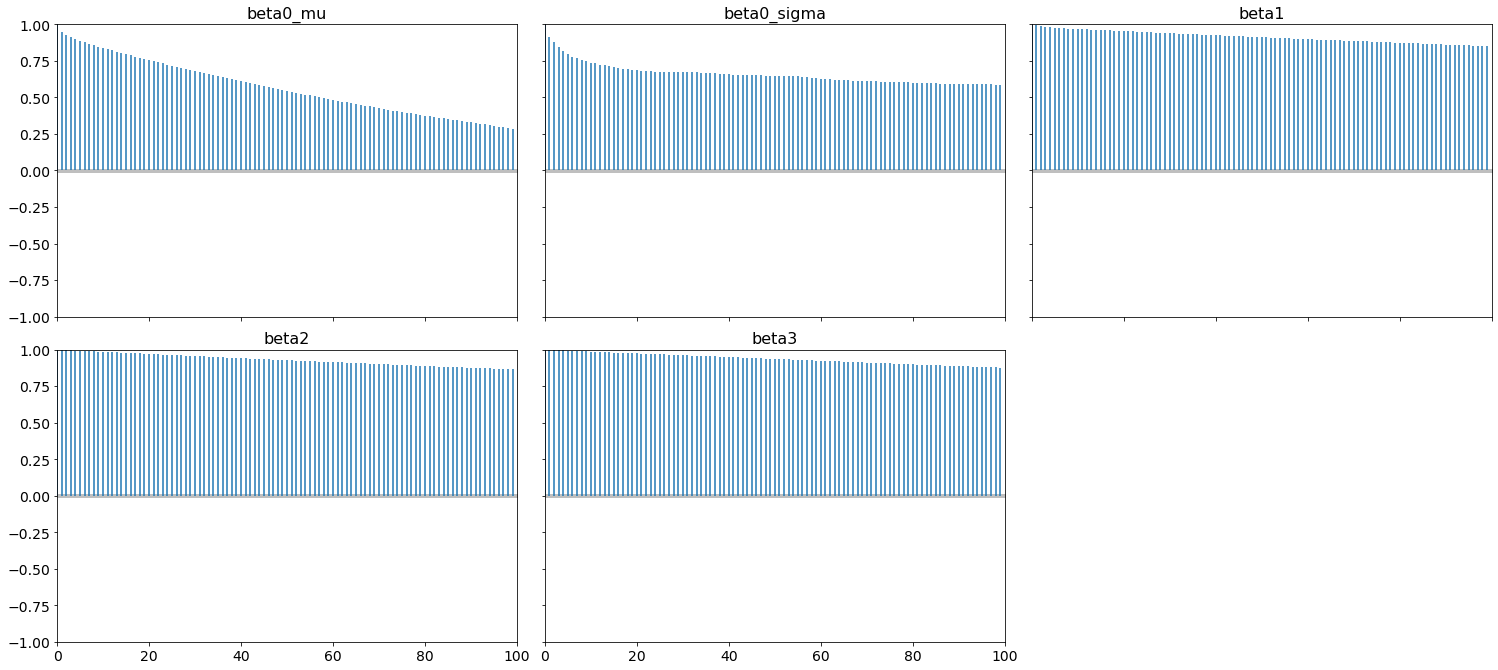

###############################
Trace plots


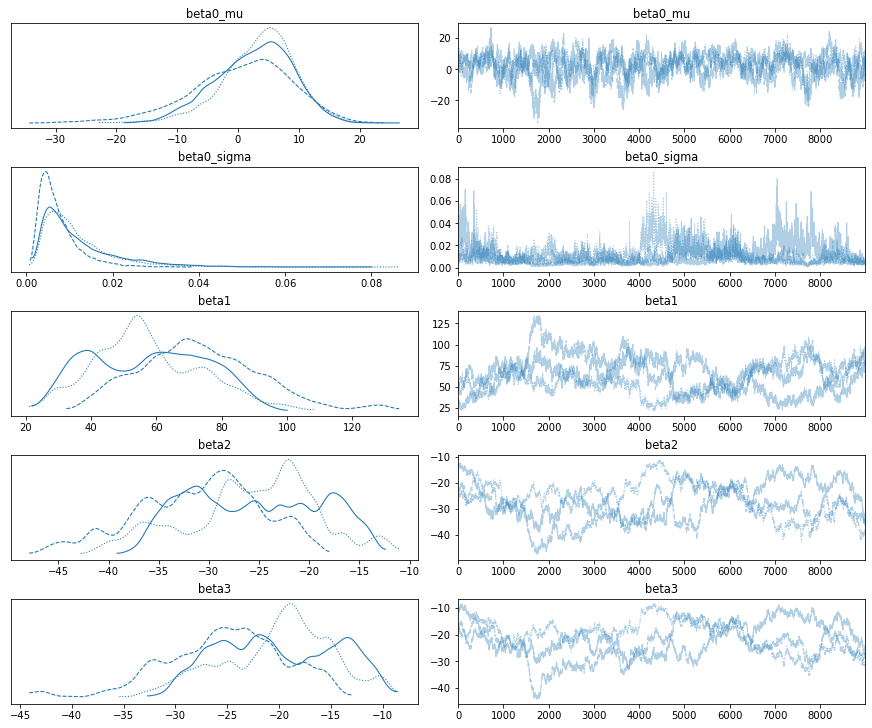

In [33]:
names = ['beta0_mu','beta0_sigma','beta1','beta2','beta3']
mcmc_diagnostics(samples, burnin, names)

# example 1 - no sens, no spec

In [120]:
np.random.seed(23)
np.set_printoptions(precision=2) # digits of precision for floating point
N = 100
x1 = np.random.uniform(0, 10, N)
x2 = np.random.uniform(0, 10, N)
beta0 = 1
beta1 = 0.2
beta2 = -0.5
logit_p = beta0 + beta1 * x1 + beta2 * x2
# p = np.exp(logit_p)/(1+np.exp(logit_p)) # inverse logit
p = expit(logit_p) # inverse logit
y = np.random.binomial(1,p,N)
precision = 0.001

model_code = '''
model {
    # Likelihood
    for (i in 1:N) {
        # y[i] ~ dbin(p[i], 1)
        y[i] ~ dbern(p[i])
        logit(p[i]) <- beta0 + beta1 * x1[i] + beta2 * x2[i]
    }
    # Priors
    beta0 ~ dnorm(0.0,0.001)
    beta1 ~ dnorm(0.0,0.001)
    beta2 ~ dnorm(0.0,0.001)
}
'''

# Set up the model
dat = dict(
    x1=x1,
    x2=x2,
    y=y,
    N=N
)
model = pj.Model(
    code=model_code,
    data=dat,
    chains=4
)

# Burn-in and thinning
burnin_samples = model.sample(500, vars=[], thin = 2)

# Post-burn-in and saving results
param_names = ['beta0', 'beta1', 'beta2']
post_samples = model.sample(10000,
                       vars=param_names)
idata = az.from_pyjags(post_samples)


adapting: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 2000 of 2000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 40000 of 40000, elapsed 0:00:05, remaining 0:00:00


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,1.147,0.647,-0.070,2.369,0.012,0.009,2879.0,5925.0,1.0
beta1,0.258,0.101,0.067,0.450,0.002,0.001,3333.0,6264.0,1.0
beta2,-0.634,0.123,-0.876,-0.414,0.002,0.001,3558.0,6470.0,1.0


array([<AxesSubplot:title={'center':'beta0'}>,
       <AxesSubplot:title={'center':'beta1'}>,
       <AxesSubplot:title={'center':'beta2'}>], dtype=object)

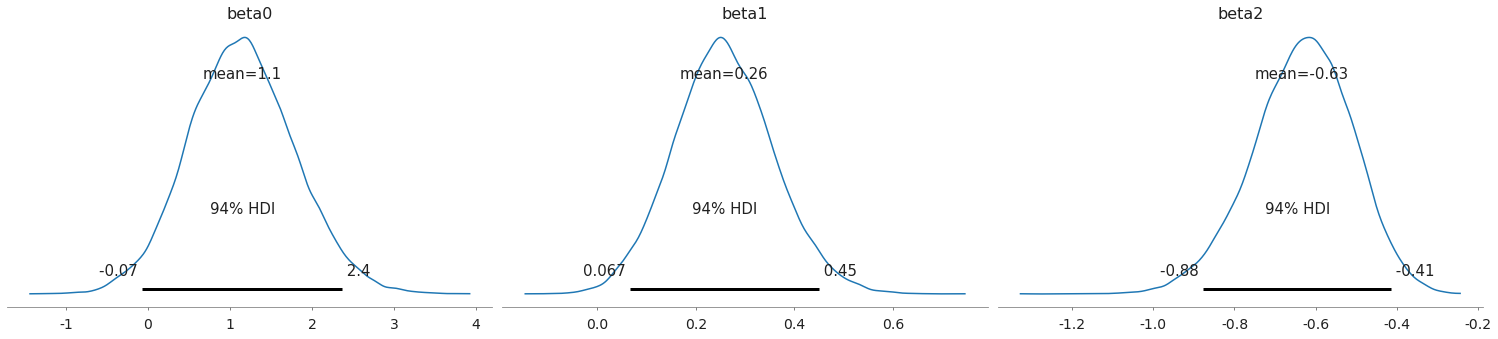

In [123]:
az.summary(idata)
az.plot_posterior(idata)

# example 2 - spec and sens

In [131]:
np.random.seed(23)
np.set_printoptions(precision=2) # digits of precision for floating point
N = 10000
x1 = np.random.uniform(0, 10, N)
x2 = np.random.uniform(0, 10, N)
beta0 = 1
beta1 = 0.2
beta2 = -0.5
se = 0.8
sp = 0.6
logit_p = beta0 + beta1 * x1 + beta2 * x2
# p = np.exp(logit_p)/(1+np.exp(logit_p)) # inverse logit
p = expit(logit_p) # inverse logit
y = np.random.binomial(1,se*p + (1-sp)*(1-p),N)
precision = 0.001

model_code = '''
model {
    # Likelihood
    for (i in 1:N) {
        # y[i] ~ dbin(p[i], 1)
        y[i] ~ dbern(se*p[i] + (1-sp)*(1-p[i]))
        logit(p[i]) <- beta0 + beta1 * x1[i] + beta2 * x2[i]
    }
    # Priors
    se ~ dbeta(5,5)
    sp ~ dbeta(5,5)
    beta0 ~ dnorm(0.0,0.001)
    beta1 ~ dnorm(0.0,0.001)
    beta2 ~ dnorm(0.0,0.001)
}
'''

# Set up the model
dat = dict(
    x1=x1,
    x2=x2,
    y=y,
    N=N
)
model = pj.Model(
    code=model_code,
    data=dat,
    chains=4
)

# Burn-in and thinning
burnin_samples = model.sample(500, vars=[], thin = 2)

# Post-burn-in and saving results
param_names = ['beta0','beta1','beta2','se','sp']
post_samples = model.sample(10000,
                       vars=param_names)
idata = az.from_pyjags(post_samples)


adapting: iterations 32 of 4000, elapsed 0:00:06, remaining 0:13:23
adapting: iterations 32 of 4000, elapsed 0:00:12, remaining 0:24:42


KeyboardInterrupt: 

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,0.455,28.915,-53.997,57.313,0.441,0.312,4276.0,6214.0,1.00
beta1,-0.242,25.777,-45.475,44.530,1.738,1.231,238.0,1459.0,1.02
beta2,0.756,39.753,-67.727,67.230,2.722,1.927,247.0,1571.0,1.02


array([<AxesSubplot:title={'center':'beta0'}>,
       <AxesSubplot:title={'center':'beta1'}>,
       <AxesSubplot:title={'center':'beta2'}>], dtype=object)

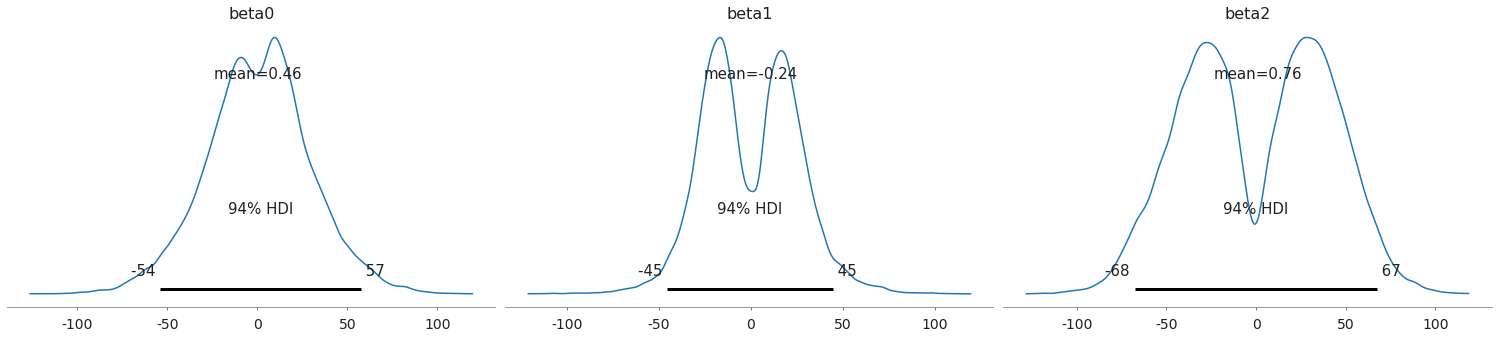

In [125]:
az.summary(idata)
az.plot_posterior(idata)

In [ ]:
idata = az.from_pyjags(samples)
print('###############################\nR-hat')
print(az.rhat(idata,
              var_names=param_names))
print('###############################\nEffective sample sizes')
print(az.ess(idata,
              var_names=param_names))
print('###############################\nAutocorrelation')
az.plot_autocorr(idata,
                 var_names=param_names,
                 combined=True)
plt.show()
print('###############################\nTrace plots')
az.plot_trace(idata, 
              var_names=param_names,
              legend=True)

In [13]:
samples = az.from_pyjags(samples).to_dataframe()


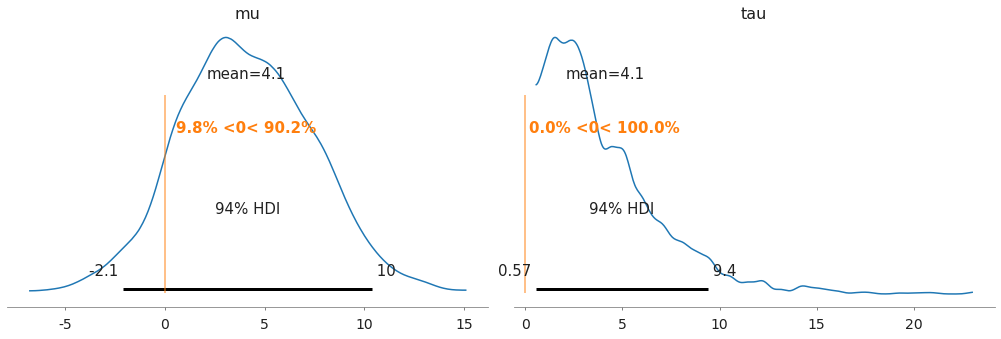

In [33]:
data = az.load_arviz_data('centered_eight')
ax = az.plot_posterior(data, var_names='mu,tau'.split(','), ref_val=[0,0])aget 

# only vax/unvax as predictor

In [289]:
# params
seed = 23
np.random.seed(seed)
N = 200
se = 0.5
sp = 0.5
alpha = 0.7
p0 = 0.6
beta0 = np.log(p0/(1-p0))
beta1 = np.log(alpha)
vax_prob = 0.5

# simulate data
x1 = bernoulli.rvs(vax_prob, size=N) # vaccinated (1)/unvaccinated (0)

X = pd.DataFrame({
    'vax': x1,
    })

beta_vec = np.array([beta0, beta1])


X['prob_TD'] = X.apply(lambda row: expit(np.dot(np.array([1, row['vax']]), beta_vec)), axis=1)
# X['TD'] = (X['prob_TD']>0.5).astype(int)

X['test_TD'] = X['prob_TD'].apply(lambda x: bernoulli.rvs(se*x + (1-sp)*(1-x)))
y = X['test_TD']
X.head()
# X['prob_TD'].describe()


model_code = '''
model {
# Likelihood
for (i in 1:N) {
y[i] ~ dbern(se*p[i] + (1-sp)*(1-p[i]))
logit(p[i]) <- beta0 + beta1 * x1[i]
}
# Priors
# se ~ dbeta(5,5)
# sp ~ dbeta(5,5)
se = 0.5
sp = 0.5
beta0 ~ dnorm(0.0,0.01)
beta1_pos ~ dgamma(2, 4)
beta1 = -1*beta1_pos
}
'''

filename = os.path.join(DATA_DIR,f'beta0{beta0:.3f}_norm(0,0.01)_beta1{beta1:.3f}_gamma(2,4)_se{se}_sp{sp}_seed{seed}_N{N}_alpha{alpha}vaxProb{vax_prob}.nc')

# Set up the model
n_burnin = 500
n_samples = 10000
n_chains = 3

dat = dict(
    x1=x1,
    y=y,
    N=N
)
model = pj.Model(
    code=model_code,
    data=dat,
    chains=n_chains
)

# Burn-in and thinning
burnin_samples = model.sample(n_burnin, vars=[], thin = 2)

# Post-burn-in and saving results
param_names = ['beta0','beta1','se','sp']
post_samples = model.sample(n_samples,
                           vars=param_names)
idata = az.from_pyjags(post_samples)


info_2_save = {'N': N, # sample size
               'p0': p0,
               'beta0': {'true': beta0, 'prior': 'norm(0,0.01)'},
               'beta1': {'true': beta1, 'prior': '-gamma(2,4)'},
               'se': {'true': se, 'prior': 'delta(true)'}, # sensitivity; "delta"=fixed se
               'sp': {'true': se, 'prior': 'delta(true)'}, # specificity; "delta"=fixed sp
               'seed': seed, # RNG seed
               'alpha': alpha, # true VE=1-alpha
               'vax_prob': vax_prob, # probability people are vaccinated
               'idata': idata # inference data
              }

pickle_object(filename, info_2_save)


,vax,prob_TD,test_TD
0,1,0.512195,0
1,1,0.512195,1
2,1,0.512195,0
3,0,0.600000,1
4,0,0.600000,1


adapting: iterations 3000 of 3000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 1500 of 1500, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 30000 of 30000, elapsed 0:00:02, remaining 0:00:00


# consistency - known se & sp

In [389]:
# Set up the model
n_burnin = 1000
n_samples = 10000
n_chains = 3

vax_prob = 0.5
N = 1000
se_a, se_b = 6, 2
sp_a, sp_b = 6, 2
beta0_mu, beta0_prec = 0, 0.01
beta1_a, beta1_b = 2, 4
# se_str = jags_distribution('beta',{'a':se_a,'b':se_b})
# sp_str = jags_distribution('beta',{'a':sp_a,'b':sp_b})
se_str = jags_distribution('fixed',{'val': 0.9})
sp_str = jags_distribution('fixed',{'val': 0.9})
beta0_str = jags_distribution('norm',{'mu':beta0_mu,'precision':beta0_prec})
beta1_str = jags_distribution('gamma',{'a':beta1_a,'b':beta1_b})

model_code = '\nmodel {{\n# Likelihood\nfor (i in 1:N) {{\ny[i] ~ dbern(se*p[i] + (1-sp)*(1-p[i]))\nlogit(p[i]) <- beta0 + beta1 * x1[i]\n}}\n# Priors\nse{0}\nsp{1}\nbeta0{2}\nbeta1_pos{3}\nbeta1 = -1*beta1_pos\n}}\n'.format(se_str, sp_str, beta0_str, beta1_str)

print(model_code)
rows = []
for ii in range(0,200):
    # draw params from priors
#     se = beta.rvs(a=se_a, b=se_b)
#     sp = beta.rvs(a=sp_a, b=sp_b)
    se = 0.9
    sp = 0.9
    beta0 = norm.rvs(loc=beta0_mu, scale=1/np.sqrt(beta0_prec))
    beta1 = -1*gamma.rvs(a=beta1_a, scale=1/beta1_b)
    true_vals = {'se': se, 'sp': sp, 'beta0': beta0, 'beta1': beta1}
    
    print(f'### TRUE VALUES (iter={ii})\n{true_vals}')
    # simulate data
    x1 = bernoulli.rvs(vax_prob, size=N) # vaccinated (1)/unvaccinated (0)
    X = pd.DataFrame({
        'vax': x1,
        })

    beta_vec = np.array([beta0, beta1])
    X['prob_TD'] = X.apply(lambda row: expit(np.dot(np.array([1, row['vax']]), beta_vec)), axis=1)
    X['test_TD'] = X['prob_TD'].apply(lambda x: bernoulli.rvs(se*x + (1-sp)*(1-x)))
    y = X['test_TD']
    
    dat = dict(
        x1=x1,
        y=y,
        N=N
    )
    model = pj.Model(
        code=model_code,
        data=dat,
        chains=n_chains
    )

    # Burn-in and thinning
    burnin_samples = model.sample(n_burnin, vars=[], thin = 2)

    # Post-burn-in and saving results
    param_names = ['beta0','beta1','se','sp']
    post_samples = model.sample(n_samples,
                               vars=param_names)
    idata = az.from_pyjags(post_samples)
    hdpis = az.hdi(idata).to_dataframe()
    for param in hdpis.columns:
        rows.append([ii, param, true_vals[param], hdpis[param][0], hdpis[param][1]])
        
        


model {
# Likelihood
for (i in 1:N) {
y[i] ~ dbern(se*p[i] + (1-sp)*(1-p[i]))
logit(p[i]) <- beta0 + beta1 * x1[i]
}
# Priors
se=0.9
sp=0.9
beta0~dnorm(0, 0.01)
beta1_pos~dgamma(2, 4)
beta1 = -1*beta1_pos
}

### TRUE VALUES
{'se': 0.9, 'sp': 0.9, 'beta0': -1.9034682533997849, 'beta1': -0.45990254049437185}
adapting: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 30000 of 30000, elapsed 0:00:09, remaining 0:00:00
sampling: iterations 30000 of 30000, elapsed 0:00:09, remaining 0:00:00
### TRUE VALUES
{'se': 0.9, 'sp': 0.9, 'beta0': -0.7061986801264222, 'beta1': -0.97377831178225}
adapting: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 30000 of 30000, elapsed 0:00:09, remaining 0:00:00
sampling: iterations 30000 of 30000, elapsed 0:00:09, remaining 0:00:00
### TRUE VALUES
{'se': 0.9

### TRUE VALUES
{'se': 0.9, 'sp': 0.9, 'beta0': -20.978619078306878, 'beta1': -0.18289518229484125}
adapting: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 30000 of 30000, elapsed 0:00:08, remaining 0:00:00
sampling: iterations 30000 of 30000, elapsed 0:00:08, remaining 0:00:00
### TRUE VALUES
{'se': 0.9, 'sp': 0.9, 'beta0': 11.077995622369647, 'beta1': -0.7110044729221815}
adapting: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 30000 of 30000, elapsed 0:00:08, remaining 0:00:00
sampling: iterations 30000 of 30000, elapsed 0:00:08, remaining 0:00:00
### TRUE VALUES
{'se': 0.9, 'sp': 0.9, 'beta0': 3.254659959869863, 'beta1': -0.11632622229423131}
adapting: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00

adapting: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 17235 of 30000, elapsed 0:00:06, remaining 0:00:04
sampling: iterations 30000 of 30000, elapsed 0:00:10, remaining 0:00:00
### TRUE VALUES
{'se': 0.9, 'sp': 0.9, 'beta0': 8.556889188672029, 'beta1': -0.41314348495569886}
adapting: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 15711 of 30000, elapsed 0:00:05, remaining 0:00:05
sampling: iterations 30000 of 30000, elapsed 0:00:10, remaining 0:00:00
### TRUE VALUES
{'se': 0.9, 'sp': 0.9, 'beta0': 5.895399178895381, 'beta1': -1.2737693251361801}
adapting: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 29658 of 30000, elapsed 0:00:10, remaining 0:00:00
sampling: iterations 3000

sampling: iterations 30000 of 30000, elapsed 0:00:10, remaining 0:00:00
### TRUE VALUES
{'se': 0.9, 'sp': 0.9, 'beta0': 0.02366619271376833, 'beta1': -0.5178894361377077}
adapting: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 30000 of 30000, elapsed 0:00:10, remaining 0:00:00
sampling: iterations 30000 of 30000, elapsed 0:00:10, remaining 0:00:00
### TRUE VALUES
{'se': 0.9, 'sp': 0.9, 'beta0': -2.4259154630836384, 'beta1': -1.0805355994536068}
adapting: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 30000 of 30000, elapsed 0:00:09, remaining 0:00:00
sampling: iterations 30000 of 30000, elapsed 0:00:09, remaining 0:00:00
### TRUE VALUES
{'se': 0.9, 'sp': 0.9, 'beta0': -17.467381637954446, 'beta1': -0.2897687051227061}
adapting: iterations 3000 of 3000, elapsed 0:00:01, remaining 0

adapting: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 23388 of 30000, elapsed 0:00:09, remaining 0:00:03
sampling: iterations 30000 of 30000, elapsed 0:00:12, remaining 0:00:00
### TRUE VALUES
{'se': 0.9, 'sp': 0.9, 'beta0': -9.264394569995538, 'beta1': -0.27597879167898876}
adapting: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 13245 of 30000, elapsed 0:00:05, remaining 0:00:06
sampling: iterations 30000 of 30000, elapsed 0:00:11, remaining 0:00:00
sampling: iterations 30000 of 30000, elapsed 0:00:11, remaining 0:00:00
### TRUE VALUES
{'se': 0.9, 'sp': 0.9, 'beta0': -15.908497599930262, 'beta1': -1.4210861119344151}
adapting: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 1

sampling: iterations 30000 of 30000, elapsed 0:00:08, remaining 0:00:00
sampling: iterations 30000 of 30000, elapsed 0:00:08, remaining 0:00:00
### TRUE VALUES
{'se': 0.9, 'sp': 0.9, 'beta0': 1.361434384679328, 'beta1': -1.4784807822793766}
adapting: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 16464 of 30000, elapsed 0:00:05, remaining 0:00:04
sampling: iterations 30000 of 30000, elapsed 0:00:09, remaining 0:00:00
### TRUE VALUES
{'se': 0.9, 'sp': 0.9, 'beta0': 7.725626351957603, 'beta1': -0.11414796800734962}
adapting: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 30000 of 30000, elapsed 0:00:08, remaining 0:00:00
sampling: iterations 30000 of 30000, elapsed 0:00:08, remaining 0:00:00
### TRUE VALUES
{'se': 0.9, 'sp': 0.9, 'beta0': -6.695046225350564, 'beta1': -1.5448725220751

adapting: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 19839 of 30000, elapsed 0:00:06, remaining 0:00:03
sampling: iterations 30000 of 30000, elapsed 0:00:08, remaining 0:00:00
### TRUE VALUES
{'se': 0.9, 'sp': 0.9, 'beta0': 21.877991928060677, 'beta1': -0.402867569012132}
adapting: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 19392 of 30000, elapsed 0:00:05, remaining 0:00:03
sampling: iterations 30000 of 30000, elapsed 0:00:08, remaining 0:00:00
### TRUE VALUES
{'se': 0.9, 'sp': 0.9, 'beta0': -19.581361895791176, 'beta1': -0.36459762352522773}
adapting: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 17865 of 30000, elapsed 0:00:05, remaining 0:00:03
sampling: iterations 30

sampling: iterations 30000 of 30000, elapsed 0:00:09, remaining 0:00:00
### TRUE VALUES
{'se': 0.9, 'sp': 0.9, 'beta0': 8.240699229710762, 'beta1': -1.0574548368876926}
adapting: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 30000 of 30000, elapsed 0:00:08, remaining 0:00:00
sampling: iterations 30000 of 30000, elapsed 0:00:08, remaining 0:00:00
### TRUE VALUES
{'se': 0.9, 'sp': 0.9, 'beta0': 7.500851675003609, 'beta1': -0.5513379808057451}
adapting: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 18612 of 30000, elapsed 0:00:05, remaining 0:00:03
sampling: iterations 30000 of 30000, elapsed 0:00:08, remaining 0:00:00
### TRUE VALUES
{'se': 0.9, 'sp': 0.9, 'beta0': 15.017277903395671, 'beta1': -0.13309063421496553}
adapting: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:

adapting: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 30000 of 30000, elapsed 0:00:08, remaining 0:00:00
sampling: iterations 30000 of 30000, elapsed 0:00:08, remaining 0:00:00
### TRUE VALUES
{'se': 0.9, 'sp': 0.9, 'beta0': -3.469852192998956, 'beta1': -0.7960471761685327}
adapting: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 30000 of 30000, elapsed 0:00:09, remaining 0:00:00
sampling: iterations 30000 of 30000, elapsed 0:00:09, remaining 0:00:00
### TRUE VALUES
{'se': 0.9, 'sp': 0.9, 'beta0': 3.0297492512574093, 'beta1': -0.07165180010565099}
adapting: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 18015 of 30000, elapsed 0:00:05, remaining 0:00:03
sampling: iterations 30

sampling: iterations 30000 of 30000, elapsed 0:00:09, remaining 0:00:00
### TRUE VALUES
{'se': 0.9, 'sp': 0.9, 'beta0': -5.696791765417586, 'beta1': -1.2555712925377343}
adapting: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 19680 of 30000, elapsed 0:00:06, remaining 0:00:03
sampling: iterations 30000 of 30000, elapsed 0:00:09, remaining 0:00:00
### TRUE VALUES
{'se': 0.9, 'sp': 0.9, 'beta0': -4.8533682828593685, 'beta1': -0.6646301652345677}
adapting: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 29370 of 30000, elapsed 0:00:09, remaining 0:00:00
sampling: iterations 30000 of 30000, elapsed 0:00:09, remaining 0:00:00
### TRUE VALUES
{'se': 0.9, 'sp': 0.9, 'beta0': 0.3966507475604495, 'beta1': -0.24506772361927887}
adapting: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:

In [410]:
df = pd.DataFrame(rows, columns=['sim','param','true','low','up'])

info_2_save = {'N': N, # sample size
               'code': model_code,
               'n_samples': n_samples,
               'n_burnin': n_burnin,
               'vax_prob': vax_prob, # probability people are vaccinated
               'df': df, # inference data
              }
pickle_object('./processed_data/hdi_consistency_fixed_se_sp.pkl', info_2_save)

In [411]:
unpickle_object('./processed_data/hdi_consistency_fixed_se_sp.pkl')

{'N': 1000,
 'code': '\nmodel {\n# Likelihood\nfor (i in 1:N) {\ny[i] ~ dbern(se*p[i] + (1-sp)*(1-p[i]))\nlogit(p[i]) <- beta0 + beta1 * x1[i]\n}\n# Priors\nse=0.9\nsp=0.9\nbeta0~dnorm(0, 0.01)\nbeta1_pos~dgamma(2, 4)\nbeta1 = -1*beta1_pos\n}\n',
 'n_samples': 10000,
 'n_burnin': 1000,
 'vax_prob': 0.5,
 'df':      sim  param       true        low        up
 0      0  beta0  -1.903468  -1.995967 -1.400535
 1      0  beta1  -0.459903  -0.771900 -0.049962
 2      0     se   0.900000   0.900000  0.900000
 3      0     sp   0.900000   0.900000  0.900000
 4      1  beta0  -0.706199  -0.993651 -0.540122
 ..   ...    ...        ...        ...       ...
 795  198     sp   0.900000   0.900000  0.900000
 796  199  beta0 -21.267420 -19.962102 -3.032649
 797  199  beta1  -0.864385  -1.162849 -0.009140
 798  199     se   0.900000   0.900000  0.900000
 799  199     sp   0.900000   0.900000  0.900000
 
 [800 rows x 5 columns]}

# consistency - unknown se & sp

In [413]:
# Set up the model
n_burnin = 1000
n_samples = 5000
n_chains = 3

vax_prob = 0.5
N = 5000
se_a, se_b = 6, 2
sp_a, sp_b = 6, 2
beta0_mu, beta0_prec = 0, 0.01
beta1_a, beta1_b = 2, 4
se_str = jags_distribution('beta',{'a':se_a,'b':se_b})
sp_str = jags_distribution('beta',{'a':sp_a,'b':sp_b})
beta0_str = jags_distribution('norm',{'mu':beta0_mu,'precision':beta0_prec})
beta1_str = jags_distribution('gamma',{'a':beta1_a,'b':beta1_b})

model_code = '\nmodel {{\n# Likelihood\nfor (i in 1:N) {{\ny[i] ~ dbern(se*p[i] + (1-sp)*(1-p[i]))\nlogit(p[i]) <- beta0 + beta1 * x1[i]\n}}\n# Priors\nse{0}\nsp{1}\nbeta0{2}\nbeta1_pos{3}\nbeta1 = -1*beta1_pos\n}}\n'.format(se_str, sp_str, beta0_str, beta1_str)

rows = []
idatas = []
for ii in range(0,100):
    # draw params from priors
    se = beta.rvs(a=se_a, b=se_b)
    sp = beta.rvs(a=sp_a, b=sp_b)
    beta0 = norm.rvs(loc=beta0_mu, scale=1/np.sqrt(beta0_prec))
    beta1 = -1*gamma.rvs(a=beta1_a, scale=1/beta1_b)
    true_vals = {'se': se, 'sp': sp, 'beta0': beta0, 'beta1': beta1}
    
    print(f'### TRUE VALUES (iter={ii})\n{true_vals}')
    # simulate data
    x1 = bernoulli.rvs(vax_prob, size=N) # vaccinated (1)/unvaccinated (0)
    X = pd.DataFrame({
        'vax': x1,
        })

    beta_vec = np.array([beta0, beta1])
    X['prob_TD'] = X.apply(lambda row: expit(np.dot(np.array([1, row['vax']]), beta_vec)), axis=1)
    X['test_TD'] = X['prob_TD'].apply(lambda x: bernoulli.rvs(se*x + (1-sp)*(1-x)))
    y = X['test_TD']
    
    dat = dict(
        x1=x1,
        y=y,
        N=N
    )
    model = pj.Model(
        code=model_code,
        data=dat,
        chains=n_chains
    )

    # Burn-in and thinning
    burnin_samples = model.sample(n_burnin, vars=[], thin = 2)

    # Post-burn-in and saving results
    param_names = ['beta0','beta1','se','sp']
    post_samples = model.sample(n_samples,
                               vars=param_names)
    idata = az.from_pyjags(post_samples)
    idatas.append(idata)
    hdpis = az.hdi(idata, hdi_prob=0.95).to_dataframe()
    for param in hdpis.columns:
        rows.append([ii, param, true_vals[param], hdpis[param][0], hdpis[param][1]])
        
df = pd.DataFrame(rows, columns=['sim','param','true','low','up'])

info_2_save = {'N': N, # sample size
               'code': model_code,
               'n_samples': n_samples,
               'n_burnin': n_burnin,
               'vax_prob': vax_prob, # probability people are vaccinated
               'df': df, # inference data
               'idatas': idatas
              }
pickle_object('./processed_data/hdi_consistency_variable_se_sp.pkl', info_2_save)


model {
# Likelihood
for (i in 1:N) {
y[i] ~ dbern(se*p[i] + (1-sp)*(1-p[i]))
logit(p[i]) <- beta0 + beta1 * x1[i]
}
# Priors
se~dbeta(6, 2)
sp~dbeta(6, 2)
beta0~dnorm(0, 0.01)
beta1_pos~dgamma(2, 4)
beta1 = -1*beta1_pos
}

### TRUE VALUES (iter=0)
{'se': 0.7353200260407333, 'sp': 0.78739811653865, 'beta0': 17.91437510645444, 'beta1': -0.1287127165956667}
adapting: iterations 873 of 3000, elapsed 0:00:06, remaining 0:00:15
adapting: iterations 2310 of 3000, elapsed 0:00:15, remaining 0:00:04
adapting: iterations 3000 of 3000, elapsed 0:00:19, remaining 0:00:00
sampling: iterations 1398 of 3000, elapsed 0:00:11, remaining 0:00:12
sampling: iterations 2754 of 3000, elapsed 0:00:20, remaining 0:00:02
sampling: iterations 3000 of 3000, elapsed 0:00:22, remaining 0:00:00
sampling: iterations 1062 of 15000, elapsed 0:00:09, remaining 0:01:53
sampling: iterations 1677 of 15000, elapsed 0:00:16, remaining 0:02:04
sampling: iterations 2211 of 15000, elapsed 0:00:21, remaining 0:02:01
sampling:

sampling: iterations 3000 of 3000, elapsed 0:00:20, remaining 0:00:00
sampling: iterations 3000 of 3000, elapsed 0:00:20, remaining 0:00:00
sampling: iterations 1194 of 15000, elapsed 0:00:08, remaining 0:01:32
sampling: iterations 2703 of 15000, elapsed 0:00:17, remaining 0:01:19
sampling: iterations 4266 of 15000, elapsed 0:00:27, remaining 0:01:08
sampling: iterations 5838 of 15000, elapsed 0:00:37, remaining 0:00:58
sampling: iterations 7431 of 15000, elapsed 0:00:46, remaining 0:00:47
sampling: iterations 8232 of 15000, elapsed 0:00:51, remaining 0:00:42
sampling: iterations 9834 of 15000, elapsed 0:01:01, remaining 0:00:32
sampling: iterations 10632 of 15000, elapsed 0:01:06, remaining 0:00:27
sampling: iterations 11430 of 15000, elapsed 0:01:12, remaining 0:00:22
sampling: iterations 12225 of 15000, elapsed 0:01:17, remaining 0:00:17
sampling: iterations 13815 of 15000, elapsed 0:01:27, remaining 0:00:07
sampling: iterations 14607 of 15000, elapsed 0:01:32, remaining 0:00:02
sam

sampling: iterations 10704 of 15000, elapsed 0:01:30, remaining 0:00:36
sampling: iterations 11298 of 15000, elapsed 0:01:35, remaining 0:00:31
sampling: iterations 12483 of 15000, elapsed 0:01:45, remaining 0:00:21
sampling: iterations 13077 of 15000, elapsed 0:01:50, remaining 0:00:16
sampling: iterations 13668 of 15000, elapsed 0:01:56, remaining 0:00:11
sampling: iterations 14256 of 15000, elapsed 0:02:02, remaining 0:00:06
sampling: iterations 14841 of 15000, elapsed 0:02:07, remaining 0:00:01
sampling: iterations 15000 of 15000, elapsed 0:02:09, remaining 0:00:00
### TRUE VALUES (iter=9)
{'se': 0.7866938057910158, 'sp': 0.8351828811240712, 'beta0': -1.7154208955980628, 'beta1': -0.3446324931397937}
adapting: iterations 978 of 3000, elapsed 0:00:09, remaining 0:00:18
adapting: iterations 1548 of 3000, elapsed 0:00:14, remaining 0:00:13
adapting: iterations 2088 of 3000, elapsed 0:00:20, remaining 0:00:09
adapting: iterations 2622 of 3000, elapsed 0:00:25, remaining 0:00:04
adaptin

sampling: iterations 5205 of 15000, elapsed 0:00:39, remaining 0:01:14
sampling: iterations 5865 of 15000, elapsed 0:00:45, remaining 0:01:10
sampling: iterations 6519 of 15000, elapsed 0:00:52, remaining 0:01:08
sampling: iterations 7143 of 15000, elapsed 0:00:59, remaining 0:01:05
sampling: iterations 7746 of 15000, elapsed 0:01:05, remaining 0:01:01
sampling: iterations 8340 of 15000, elapsed 0:01:11, remaining 0:00:57
sampling: iterations 8925 of 15000, elapsed 0:01:17, remaining 0:00:53
sampling: iterations 9501 of 15000, elapsed 0:01:23, remaining 0:00:48
sampling: iterations 10644 of 15000, elapsed 0:01:33, remaining 0:00:38
sampling: iterations 11217 of 15000, elapsed 0:01:41, remaining 0:00:34
sampling: iterations 11772 of 15000, elapsed 0:01:47, remaining 0:00:29
sampling: iterations 12321 of 15000, elapsed 0:01:53, remaining 0:00:25
sampling: iterations 12864 of 15000, elapsed 0:01:59, remaining 0:00:20
sampling: iterations 13404 of 15000, elapsed 0:02:04, remaining 0:00:15


sampling: iterations 15000 of 15000, elapsed 0:02:28, remaining 0:00:00
### TRUE VALUES (iter=18)
{'se': 0.4810035976368868, 'sp': 0.6109387424534398, 'beta0': -3.1054919223958417, 'beta1': -0.4205551194933325}
adapting: iterations 942 of 3000, elapsed 0:00:07, remaining 0:00:14
adapting: iterations 1665 of 3000, elapsed 0:00:12, remaining 0:00:10
adapting: iterations 2352 of 3000, elapsed 0:00:17, remaining 0:00:05
adapting: iterations 3000 of 3000, elapsed 0:00:24, remaining 0:00:00
adapting: iterations 3000 of 3000, elapsed 0:00:24, remaining 0:00:00
sampling: iterations 525 of 3000, elapsed 0:00:05, remaining 0:00:24
sampling: iterations 1599 of 3000, elapsed 0:00:13, remaining 0:00:11
sampling: iterations 2853 of 3000, elapsed 0:00:22, remaining 0:00:01
sampling: iterations 3000 of 3000, elapsed 0:00:23, remaining 0:00:00
sampling: iterations 1302 of 15000, elapsed 0:00:11, remaining 0:01:52
sampling: iterations 2523 of 15000, elapsed 0:00:21, remaining 0:01:42
sampling: iteration

sampling: iterations 4176 of 15000, elapsed 0:00:25, remaining 0:01:04
sampling: iterations 5013 of 15000, elapsed 0:00:30, remaining 0:01:00
sampling: iterations 6687 of 15000, elapsed 0:00:40, remaining 0:00:49
sampling: iterations 8367 of 15000, elapsed 0:00:50, remaining 0:00:39
sampling: iterations 10050 of 15000, elapsed 0:00:59, remaining 0:00:29
sampling: iterations 11742 of 15000, elapsed 0:01:09, remaining 0:00:19
sampling: iterations 13440 of 15000, elapsed 0:01:19, remaining 0:00:09
sampling: iterations 15000 of 15000, elapsed 0:01:28, remaining 0:00:00
sampling: iterations 15000 of 15000, elapsed 0:01:28, remaining 0:00:00
### TRUE VALUES (iter=24)
{'se': 0.8331853616783021, 'sp': 0.4386267604646099, 'beta0': 4.903112085618087, 'beta1': -0.64562583943844}
adapting: iterations 1284 of 3000, elapsed 0:00:08, remaining 0:00:10
adapting: iterations 2133 of 3000, elapsed 0:00:13, remaining 0:00:05
adapting: iterations 2976 of 3000, elapsed 0:00:18, remaining 0:00:00
adapting: i

sampling: iterations 2043 of 3000, elapsed 0:00:22, remaining 0:00:10
sampling: iterations 2511 of 3000, elapsed 0:00:27, remaining 0:00:05
sampling: iterations 3000 of 3000, elapsed 0:00:32, remaining 0:00:00
sampling: iterations 3000 of 3000, elapsed 0:00:32, remaining 0:00:00
sampling: iterations 501 of 15000, elapsed 0:00:05, remaining 0:02:34
sampling: iterations 1452 of 15000, elapsed 0:00:15, remaining 0:02:17
sampling: iterations 2445 of 15000, elapsed 0:00:24, remaining 0:02:03
sampling: iterations 3471 of 15000, elapsed 0:00:33, remaining 0:01:49
sampling: iterations 4539 of 15000, elapsed 0:00:41, remaining 0:01:35
sampling: iterations 5640 of 15000, elapsed 0:00:50, remaining 0:01:23
sampling: iterations 6771 of 15000, elapsed 0:00:59, remaining 0:01:12
sampling: iterations 7923 of 15000, elapsed 0:01:08, remaining 0:01:00
sampling: iterations 9096 of 15000, elapsed 0:01:17, remaining 0:00:50
sampling: iterations 10275 of 15000, elapsed 0:01:27, remaining 0:00:40
sampling: 

KeyboardInterrupt: 

In [ ]:
az.from_st

[[0, 'beta0', 5.663925892535511, 3.7972392481280326, 21.423860938744802],
 [0, 'beta1', -0.13997011839042656, -1.0996476539081552, -0.01881859876869174],
 [0, 'se', 0.9, 0.9, 0.9],
 [0, 'sp', 0.9, 0.9, 0.9]]

/opt/anaconda3/envs/bayes_ve/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/opt/anaconda3/envs/bayes_ve/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/opt/anaconda3/envs/bayes_ve/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/opt/anaconda3/envs/bayes_ve/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/opt/anaconda3/envs/bayes_ve/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/opt/anaconda3/envs/bayes_ve/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: R

array([[<AxesSubplot:title={'center':'beta0'}>,
        <AxesSubplot:title={'center':'beta0'}>],
       [<AxesSubplot:title={'center':'beta1'}>,
        <AxesSubplot:title={'center':'beta1'}>],
       [<AxesSubplot:title={'center':'se'}>,
        <AxesSubplot:title={'center':'se'}>],
       [<AxesSubplot:title={'center':'sp'}>,
        <AxesSubplot:title={'center':'sp'}>]], dtype=object)

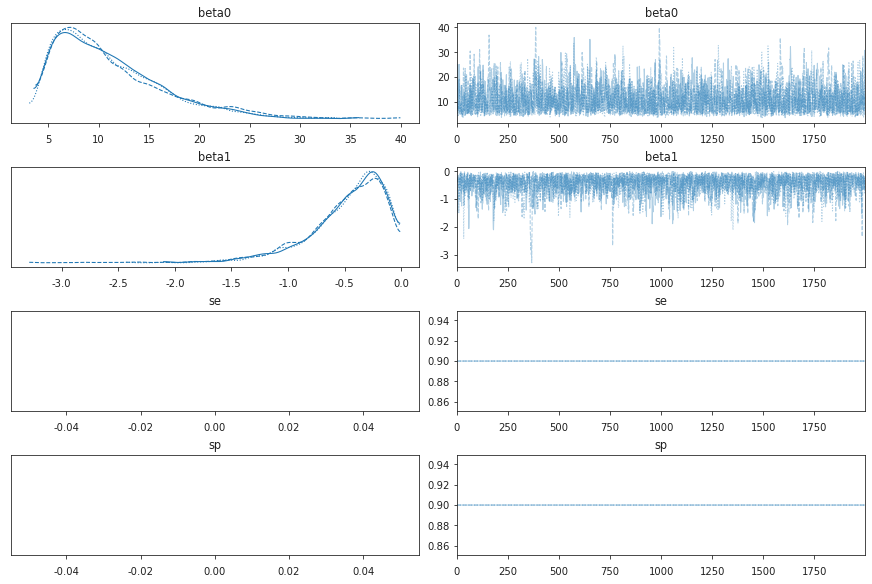

In [385]:
rows

az.plot_trace(idata)

In [348]:

# alpha = 0.7
# p0 = 0.6
# beta0 = np.log(p0/(1-p0))
# beta1 = np.log(alpha)
# vax_prob = 0.5

# # simulate data
# x1 = bernoulli.rvs(vax_prob, size=N) # vaccinated (1)/unvaccinated (0)

# X = pd.DataFrame({
#     'vax': x1,
#     })

# beta_vec = np.array([beta0, beta1])


# X['prob_TD'] = X.apply(lambda row: expit(np.dot(np.array([1, row['vax']]), beta_vec)), axis=1)
# # X['TD'] = (X['prob_TD']>0.5).astype(int)

# X['test_TD'] = X['prob_TD'].apply(lambda x: bernoulli.rvs(se*x + (1-sp)*(1-x)))
# y = X['test_TD']
# X.head()
# # X['prob_TD'].describe()


# model_code = '''
# model {
# # Likelihood
# se = 0.5
# sp = 0.5
# for (i in 1:N) {
# # y[i] ~ dbin(p[i], 1)
# y[i] ~ dbern(se*p[i] + (1-sp)*(1-p[i]))
# logit(p[i]) <- beta0 + beta1 * x1[i]
# }
# # Priors
# # se ~ dbeta(5,5)
# # sp ~ dbeta(5,5)
# beta0 ~ dnorm(0.0,0.01)
# beta1_pos ~ dgamma(2, 4)
# beta1 = -1*beta1_pos
# }
# '''

# filename = os.path.join(DATA_DIR,f'beta0{beta0:.3f}_norm(0,0.01)_beta1{beta1:.3f}_gamma(2,4)_se{se}_sp{sp}_seed{seed}_N{N}_alpha{alpha}vaxProb{vax_prob}.nc')

# # Set up the model
# n_burnin = 500
# n_samples = 2000
# n_chains = 3

# dat = dict(
#     x1=x1,
#     y=y,
#     N=N
# )
# model = pj.Model(
#     code=model_code,
#     data=dat,
#     chains=n_chains
# )

# # Burn-in and thinning
# burnin_samples = model.sample(n_burnin, vars=[], thin = 2)

# # Post-burn-in and saving results
# param_names = ['beta0','beta1','se','sp']
# post_samples = model.sample(n_samples,
#                            vars=param_names)
# idata = az.from_pyjags(post_samples)


# info_2_save = {'N': N, # sample size
#                'p0': p0,
#                'beta0': {'true': beta0, 'prior': 'norm(0,0.01)'},
#                'beta1': {'true': beta1, 'prior': '-gamma(2,4)'},
#                'se': {'true': se, 'prior': 'delta(true)'}, # sensitivity; "delta"=fixed se
#                'sp': {'true': se, 'prior': 'delta(true)'}, # specificity; "delta"=fixed sp
#                'seed': seed, # RNG seed
#                'alpha': alpha, # true VE=1-alpha
#                'vax_prob': vax_prob, # probability people are vaccinated
#                'idata': idata, # inference data
#                'code': model_code
#               }

# pickle_object(filename, info_2_save)


In [ ]:
model_code = '''
model {
# Likelihood
se = 0.5
sp = 0.5
for (i in 1:N) {
# y[i] ~ dbin(p[i], 1)
y[i] ~ dbern(se*p[i] + (1-sp)*(1-p[i]))
logit(p[i]) <- beta0 + beta1 * x1[i]
}
# Priors
# se ~ dbeta(5,5)
# sp ~ dbeta(5,5)
beta0 ~ dnorm(0.0,0.01)
beta1_pos ~ dgamma(2, 4)
beta1 = -1*beta1_pos
}
'''

In [290]:
code = '''
model {
# Likelihood
for (i in 1:N) {
# y[i] ~ dbin(p[i], 1)
y[i] ~ dbern(se*p[i] + (1-sp)*(1-p[i]))
logit(p[i]) <- beta0 + beta1 * x1[i]
}
# Priors
se ~ dbeta(5,5)
sp ~ dbeta(5,5)
beta0 ~ dnorm(0.0,0.01)
beta1_pos ~ dgamma(2, 4)
beta1 = -1*beta1_pos
}
'''

code

'\nmodel {{\n# Likelihood\nfor (i in 1:N) {{\n# y[i] ~ dbin(p[i], 1)\ny[i] ~ dbern(se*p[i] + (1-sp)*(1-p[i]))\nlogit(p[i]) <- beta0 + beta1 * x1[i]\n}}\n# Priors\nse ~ dbeta(5,5)\nsp ~ dbeta(5,5)\nbeta0 ~ dnorm(0.0,0.01)\nbeta1_pos ~ dgamma(2, 4)\nbeta1 = -1*beta1_pos\n}}\n'.fo

'\nmodel {\n# Likelihood\nfor (i in 1:N) {\n# y[i] ~ dbin(p[i], 1)\ny[i] ~ dbern(se*p[i] + (1-sp)*(1-p[i]))\nlogit(p[i]) <- beta0 + beta1 * x1[i]\n}\n# Priors\nse ~ dbeta(5,5)\nsp ~ dbeta(5,5)\nbeta0 ~ dnorm(0.0,0.01)\nbeta1_pos ~ dgamma(2, 4)\nbeta1 = -1*beta1_pos\n}\n'

In [278]:
az.hdi(idata).to_dataframe()

,beta0,beta1,se,sp
hdi,,,,
lower,-19.328303,-1.145581,0.5,0.5
higher,18.313920,-0.015883,0.5,0.5


In [252]:
pickle_object(filename, info_2_save)
unpickle_object(filenma)

Inference data with groups:
	> posterior

# diagnostics and analysis

## posterior plots

[<AxesSubplot:>]

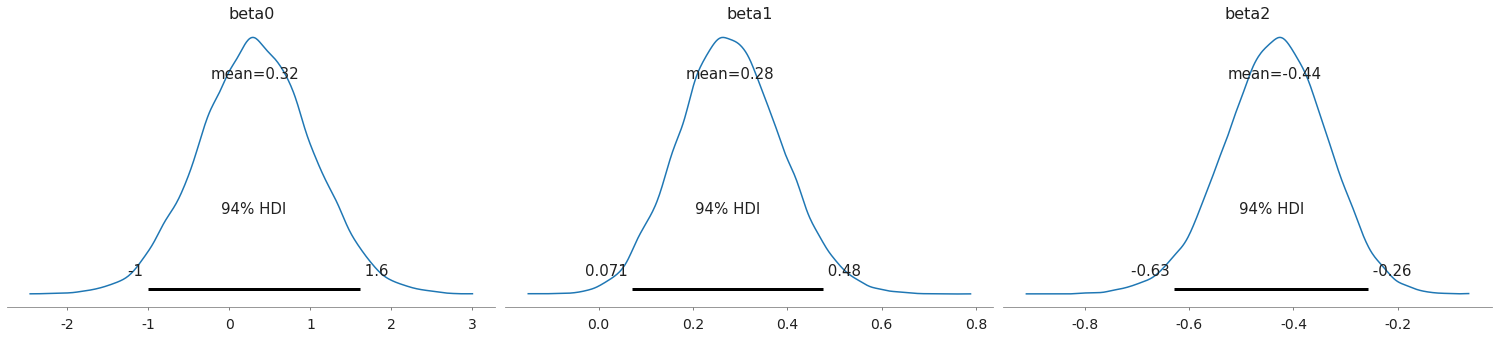

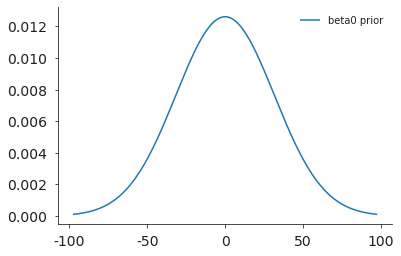

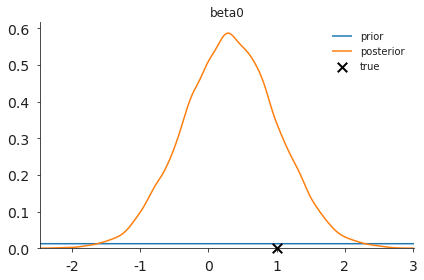

In [119]:
ax = az.plot_posterior(idata)
post = ax[0].lines[0].get_xydata()
post[:,1] = post[:,1]/auc(post[:,0], post[:,1])

precision = 0.001
ppf = lambda xx: norm.ppf(xx, loc=0, scale=1/np.sqrt(precision))
pdf = lambda xx: norm.pdf(xx, loc=0, scale=1/np.sqrt(precision))
prior = np.zeros((1000,1000))
prior[:,0] = np.linspace(ppf(0.001), ppf(0.999), 1000)
prior[:,1] = pdf(prior[:,0])


def plot_posterior_and_prior(prior, posterior, true=None, title=None):
    fig, ax = fig_setup(1,1)
    ax[0].plot(prior[:,0],prior[:,1],label='prior')
    ax[0].plot(posterior[:,0],posterior[:,1],label='posterior')
    if true is not None:
        ax[0].scatter(true, 0,
                    linewidth=2,
                    color='black',
                    marker='x',
                    s=90,
                    label='true',
                    clip_on=False,
                    zorder=100)
    ax[0].set_xlim(post[:,0].min(), post[:,0].max())
    ax[0].set_ylim(bottom=0)
    ax[0].set_title(title)

    finalize(ax[0])
    plt.tight_layout()
    
plot_pdf(prior, 'beta0 prior')
    
plot_posterior_and_prior(prior, post, beta0, 'beta0')

 Text(-1.0054229403130448, 0.04308289306453806, '-1 '),
 Text(1.6090862575178655, 0.04308289306453806, ' 1.6'),
 Text(0.30183165860241035, 0.18464097027659165, '94% HDI'),
 Text(0.3188792031184402, 0.49237592073757774, 'mean=0.32'),
 Text(0.5, 1.0, 'beta0'),
 Text(0.0, 1.0, ''),
 Text(1.0, 1.0, ''),

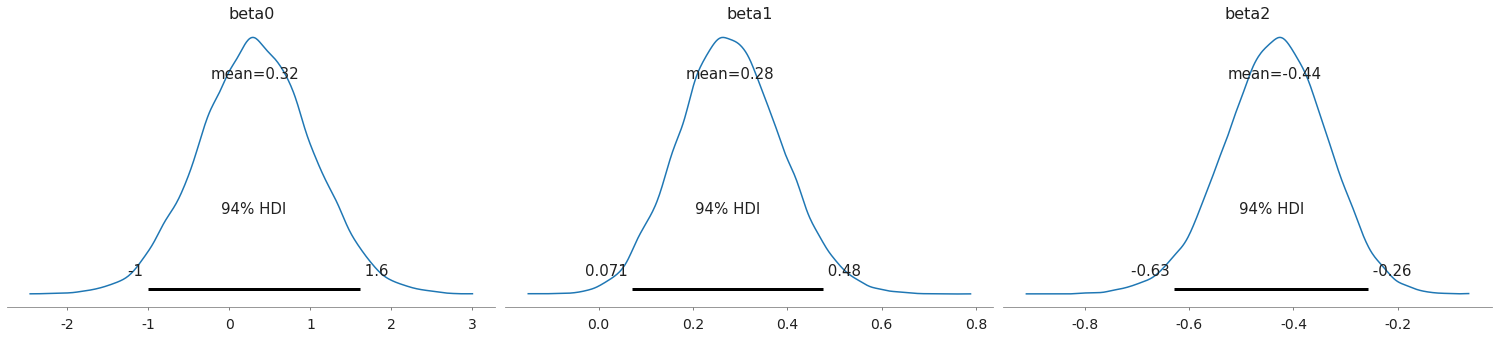

In [95]:
ax = az.plot_posterior(idata)
post = ax[0].lines[0].get_xydata()
post[:,1] = post[:,1]/auc(post[:,0], post[:,1])
ax[0].get_children()

## inferences and estimates (HDI, point)

In [94]:
az.hdi(idata, hdi_prob=0.95).to_dataframe()
az.summary(idata)

,beta0,beta1,beta2
hdi,,,
lower,-1.046099,0.069856,-0.632047
higher,1.671891,0.492168,-0.243443


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,0.319,0.696,-1.005,1.609,0.016,0.011,1848.0,4258.0,1.0
beta1,0.279,0.108,0.071,0.476,0.002,0.002,1992.0,5147.0,1.0
beta2,-0.436,0.099,-0.629,-0.256,0.002,0.001,3930.0,6872.0,1.0


In [76]:
y.sum()

5.101336141194

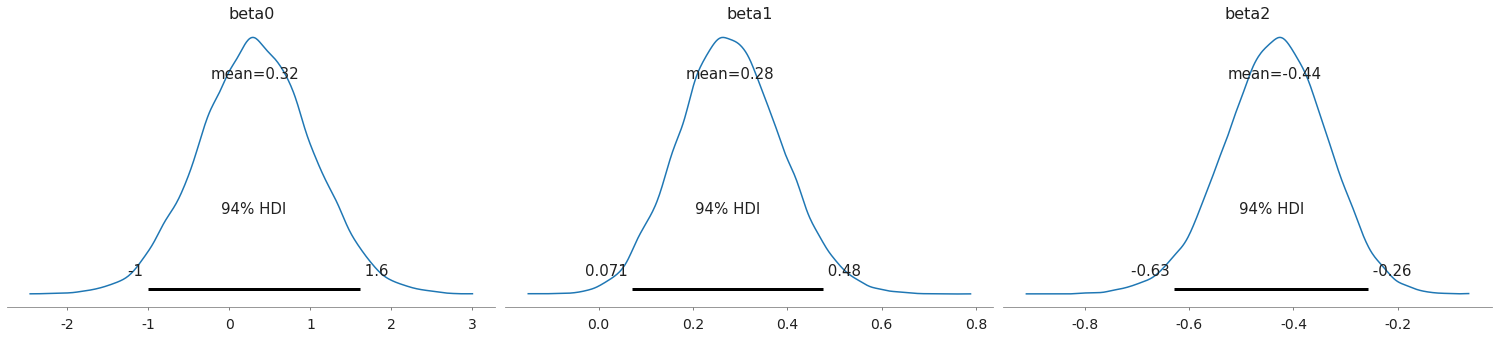

In [51]:
ax = az.plot_posterior(idata)

In [ ]:
ax[0]

In [48]:
post = ax[0].lines[0].get_xydata()
prior = 
ax[0].lines[1].get_xydata()
ax[0].lines[2].get_xydata()

ax[0].get_children()

array([[-6.81e+00,  1.41e-03],
       [-6.77e+00,  1.41e-03],
       [-6.73e+00,  1.42e-03],
       ...,
       [ 1.50e+01,  1.70e-03],
       [ 1.51e+01,  1.70e-03],
       [ 1.51e+01,  1.70e-03]])

array([[-2.12e+00,  2.41e-03],
       [ 1.04e+01,  2.41e-03]])

array([[0.  , 0.05],
       [0.  , 0.75]])

 Text(-2.1184059523571017, 0.008444397229678454, '-2.1 '),
 Text(10.403207095827112, 0.008444397229678454, ' 10'),
 Text(4.1424005717350045, 0.03619027384147908, '94% HDI'),
 Text(4.092610850912027, 0.0965073969106109, 'mean=4.1'),
 Text(4.092610850912027, 0.07238054768295817, '9.8% <0< 90.2%'),
 Text(0.5, 1.0, 'mu'),
 Text(0.0, 1.0, ''),
 Text(1.0, 1.0, ''),

In [43]:
rect.get_xy()

(0.0, 0.0)

In [30]:
# az.plot_posterior(samples)
az.from_dict(samples.to_dict())

MissingDimensionsError: 'chain' has more than 1-dimension and the same name as one of its dimensions ('chain', 'draw'). xarray disallows such variables because they conflict with the coordinates used to label dimensions.

In [28]:
samples.to_dict()

{'chain': {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0,
  10: 0,
  11: 0,
  12: 0,
  13: 0,
  14: 0,
  15: 0,
  16: 0,
  17: 0,
  18: 0,
  19: 0,
  20: 0,
  21: 0,
  22: 0,
  23: 0,
  24: 0,
  25: 0,
  26: 0,
  27: 0,
  28: 0,
  29: 0,
  30: 0,
  31: 0,
  32: 0,
  33: 0,
  34: 0,
  35: 0,
  36: 0,
  37: 0,
  38: 0,
  39: 0,
  40: 0,
  41: 0,
  42: 0,
  43: 0,
  44: 0,
  45: 0,
  46: 0,
  47: 0,
  48: 0,
  49: 0,
  50: 0,
  51: 0,
  52: 0,
  53: 0,
  54: 0,
  55: 0,
  56: 0,
  57: 0,
  58: 0,
  59: 0,
  60: 0,
  61: 0,
  62: 0,
  63: 0,
  64: 0,
  65: 0,
  66: 0,
  67: 0,
  68: 0,
  69: 0,
  70: 0,
  71: 0,
  72: 0,
  73: 0,
  74: 0,
  75: 0,
  76: 0,
  77: 0,
  78: 0,
  79: 0,
  80: 0,
  81: 0,
  82: 0,
  83: 0,
  84: 0,
  85: 0,
  86: 0,
  87: 0,
  88: 0,
  89: 0,
  90: 0,
  91: 0,
  92: 0,
  93: 0,
  94: 0,
  95: 0,
  96: 0,
  97: 0,
  98: 0,
  99: 0,
  100: 0,
  101: 0,
  102: 0,
  103: 0,
  104: 0,
  105: 0,
  106: 0,
  107: 0,
  108: 0,
  109: 0,
 

In [25]:
data.to_dataframe()

,chain,draw,"(posterior, mu)","(posterior, theta[0], Choate)","(posterior, theta[1], Deerfield)","(posterior, theta[2], Phillips Andover)","(posterior, theta[3], Phillips Exeter)","(posterior, theta[4], Hotchkiss)","(posterior, theta[5], Lawrenceville)","(posterior, theta[6], St. Paul's)",...,"(prior, theta[6], St. Paul's)","(prior, theta[7], Mt. Hermon)","(prior, obs[0], Choate)","(prior, obs[1], Deerfield)","(prior, obs[2], Phillips Andover)","(prior, obs[3], Phillips Exeter)","(prior, obs[4], Hotchkiss)","(prior, obs[5], Lawrenceville)","(prior, obs[6], St. Paul's)","(prior, obs[7], Mt. Hermon)"
0,0,0,-3.476986,1.668654,-8.537401,-2.622619,-2.509951,-4.004844,-9.174019,0.155234,...,6.135082,3.984435,-3.539971,6.769448,19.679771,-10.741723,1.594982,-13.157970,8.269640,-8.569042
1,0,1,-2.455871,-6.239359,1.071411,-4.517927,-3.341560,-3.422806,0.399546,-4.462528,...,1.730840,-0.034163,-21.166369,1.146050,-24.570783,-6.921033,-12.705194,-4.068690,-13.157913,-8.542400
2,0,2,-2.826254,2.195098,-2.920843,-3.494201,2.136533,-7.229751,-2.720302,-3.487005,...,-122.029976,-74.031724,-122.383964,22.385597,-15.761502,-52.800127,68.876046,44.242679,-129.804129,-108.183013
3,0,3,-1.995894,-3.736485,-6.342422,-5.017723,5.005665,-6.107046,-2.099592,1.145165,...,13.318479,3.548044,2.144288,34.180500,4.411558,22.045692,13.628275,20.757049,6.063963,18.748404
4,0,4,7.668982,11.738328,12.854003,-1.419241,20.278944,1.377388,18.534980,27.949800,...,3.507706,6.524663,-7.138264,0.311008,9.011283,0.734600,5.968886,4.765805,11.512443,-10.845965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,3,495,10.037602,11.161808,15.781574,9.490260,12.453176,7.582983,9.015609,11.001966,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996,3,496,9.920620,4.949339,0.661325,10.858709,4.483763,11.547203,9.790741,18.312519,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997,3,497,4.597058,14.186299,11.762716,4.684036,8.303899,-3.204281,3.357491,-0.586514,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998,3,498,5.898506,-1.420946,-4.034405,16.620064,7.119605,6.733222,-4.901925,15.850648,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# imports and functions

In [7]:
import pandas as pd
df = pd.DataFrame()
df.to_pickle

In [6]:
# imports and preprocess data
import numpy as np
import pyjags as pj
from scipy.special import expit
import arviz as az
from scipy.stats import bernoulli, uniform, norm, beta, gamma
from utilities.plotUtils import *
from sklearn.metrics import auc
from library import *
from utilities.utilityFunctions import pickle_object, unpickle_object

ImportError: attempted relative import with no known parent package

In [4]:


# def mcmc_diagnostics(samples, burnin, param_names):
# def mcmc_diagnostics(idata, param_names, param_vals=None):
# #     samples = pj.discard_burn_in_samples(samples, burn_in=burnin)

# #     idata = az.from_pyjags(samples)
#     print('###############################\nR-hat')
#     print(az.rhat(idata,
#                   var_names=param_names))
#     print('###############################\nEffective sample sizes')
#     print(az.ess(idata,
#                   var_names=param_names))
#     print('###############################\nAutocorrelation')
#     axs = az.plot_autocorr(idata,
#                      var_names=param_names,
#                      combined=True)
    
#     plt.show()
#     print('###############################\nTrace plots')
#     axs = az.plot_trace(idata, 
#                   var_names=param_names,
#                   legend=True)
#     print(type(axs), len(axs), axs.shape, type(axs[0,0]))
#     if param_vals is not None:
#         for ii in range(axs.shape[0]):
#             print(axs[ii,0].get_ylim(), axs[ii,0].get_xlim())
#             axs[ii,0].scatter(param_vals[ii], 0,
#                             linewidth=2,
#                             color='black',
#                             marker='x',
#                             s=90,
#                             label='true',
#                             clip_on=False,
#                             zorder=100)
#             x_lim = axs[ii,1].get_xlim()
#             x_vals = np.linspace(x_lim[0], x_lim[1], 200)
#             axs[ii,1].plot(x_vals, 
#                            np.repeat(param_vals[ii],len(x_vals)), 
#                            'k--',
#                            label='true'
#                           )
#     plt.show()
#     az.plot_posterior(idata, var_names=param_names)
#     plt.show()

# filename1 = '/Users/erikjohnson/python/py_packages/bayesian_logistic_regression/processed_data/beta00.405_norm(0,0.01)_beta1-0.357_gamma(2,4)_se0.5_sp0.5_seed23_N200_alpha0.7vaxProb0.5.nc'
# filename2 = '/Users/erikjohnson/python/py_packages/bayesian_logistic_regression/processed_data/beta00.405_norm(0,0.01)_beta1-0.357_gamma(2,4)_se0.9_sp0.9_seed23_N10000_alpha0.7vaxProb0.5.nc'

# idata = az.from_netcdf(filename1)
# mcmc_diagnostics(idata, ['beta0','beta1'], [beta0, beta1])

# idata = az.from_netcdf(filename2)
# mcmc_diagnostics(idata, ['beta0','beta1'], [beta0, beta1])

# automate model creation

In [295]:
code1 = '\nmodel {{\n    for (i in 1:N){{\n        Y[i] ~ dbern(se*p[i]+(1-sp)*(1-p[i]))\n        p[i] = ilogit(beta0 + beta1*x1[i] + beta2*x2[i] + beta3*x3[i])\n    }}\n    se ~ dbeta(5,5)\n    sp ~ dbeta(5,5)\n    beta0 ~ dnorm({0}, 1/10000)\n    beta1 ~ dnorm(0, 1/10000)\n    beta2 ~ dnorm(0, 1/10000)\n    beta3 ~ dnorm(0, 1/10000)\n}}\n'.format('0')
code1

'\nmodel {\n    for (i in 1:N){\n        Y[i] ~ dbern(se*p[i]+(1-sp)*(1-p[i]))\n        p[i] = ilogit(beta0 + beta1*x1[i] + beta2*x2[i] + beta3*x3[i])\n    }\n    se ~ dbeta(5,5)\n    sp ~ dbeta(5,5)\n    beta0 ~ dnorm(0, 1/10000)\n    beta1 ~ dnorm(0, 1/10000)\n    beta2 ~ dnorm(0, 1/10000)\n    beta3 ~ dnorm(0, 1/10000)\n}\n'

In [282]:
x = 2
code1 = '\nmodel {{\n    for (i in 1:N){{\n        Y[i] ~ dbern(se*p[i]+(1-sp)*(1-p[i]))\n        p[i] = ilogit(beta0 + beta1*x1[i] + beta2*x2[i] + beta3*x3[i])\n    }}\n    se ~ dbeta(5,5)\n    sp ~ dbeta(5,5)\n    beta0 ~ dnorm({0}, 1/10000)\n    beta1 ~ dnorm(0, 1/10000)\n    beta2 ~ dnorm(0, 1/10000)\n    beta3 ~ dnorm(0, 1/10000)\n}}\n'.format('0')

code2 = '''
model {
# Likelihood
se = 0.5
sp = 0.5
for (i in 1:N) {
# y[i] ~ dbin(p[i], 1)
y[i] ~ dbern(se*p[i] + (1-sp)*(1-p[i]))
logit(p[i]) <- beta0 + beta1 * x1[i]
}
# Priors
# se ~ dbeta(5,5)
# sp ~ dbeta(5,5)
beta0 ~ dnorm(0.0,0.01)
beta1_pos ~ dgamma(2, 4)
beta1 = -1*beta1_pos
}
'''

se_str = '\nmodel {{\n    for (i in 1:N){{\n        Y[i] ~ dbern(se*p[i]+(1-sp)*(1-p[i]))\n        p[i] = ilogit(beta0 + beta1*x1[i] + beta2*x2[i] + beta3*x3[i])\n    }}\n    se ~ dbeta(5,5)\n    sp ~ dbeta(5,5)\n    beta0 ~ dnorm({0}, 1/10000)\n    beta1 ~ dnorm(0, 1/10000)\n    beta2 ~ dnorm(0, 1/10000)\n    beta3 ~ dnorm(0, 1/10000)\n}}\n'.format('0')
if type(se)!=str:
    

'

'\nmodel {\n    for (i in 1:N){\n        Y[i] ~ dbern(se*p[i]+(1-sp)*(1-p[i]))\n        p[i] = ilogit(beta0 + beta1*x1[i] + beta2*x2[i] + beta3*x3[i])\n    }\n    se ~ dbeta(5,5)\n    sp ~ dbeta(5,5)\n    beta0 ~ dnorm(0, 1/10000)\n    beta1 ~ dnorm(0, 1/10000)\n    beta2 ~ dnorm(0, 1/10000)\n    beta3 ~ dnorm(0, 1/10000)\n}\n'

In [331]:
se_str = 'se = 0.5'
sp_str = 'sp = 0.5'
beta0_str = 'beta0 ~ dnorm(0.0, 0.01)'
beta1_str = 'beta1_pos ~ dgamma(2, 4)'
code2 = '\nmodel {{\n# Likelihood\nfor (i in 1:N) {{\ny[i] ~ dbern(se*p[i] + (1-sp)*(1-p[i]))\nlogit(p[i]) <- beta0 + beta1 * x1[i]\n}}\n# Priors\n{0}\n{1}\n{2}\n{3}\nbeta1 = -1*beta1_pos\n}}\n'.format(se_str, sp_str, beta0_str, beta1_str)
print(code2)



model {
# Likelihood
for (i in 1:N) {
y[i] ~ dbern(se*p[i] + (1-sp)*(1-p[i]))
logit(p[i]) <- beta0 + beta1 * x1[i]
}
# Priors
se = 0.5
sp = 0.5
beta0 ~ dnorm(0.0, 0.01)
beta1_pos ~ dgamma(2, 4)
beta1 = -1*beta1_pos
}



In [379]:
def jags_distribution(name, values):
    if name=='gamma':
        return f"~dgamma({values['a']}, {values['b']})"
    elif name=='norm':
        return f"~dnorm({values['mu']}, {values['precision']})"
    elif name=='beta':
        return f"~dbeta({values['a']}, {values['b']})"
    elif name=='fixed':
        return f"={values['val']}"
    elif name=='uni':
        return f"~dunif({values['a']}, {values['b']})"
    
jags_distribution('gamma', {'a':2, 'b':2})

'~dgamma(2, 2)'

In [301]:
print(code2)


model {
# Likelihood
for (i in 1:N) {
y[i] ~ dbern(se*p[i] + (1-sp)*(1-p[i]))
logit(p[i]) <- beta0 + beta1 * x1[i]
}
# Priors
se = 0.5
sp = 0.5
beta0 ~ dnorm(0.0, 0.01)
beta1_pos ~ dgamma(2, 4)
beta1 = -1*beta1_pos
}



# prior plots

0.6224593312018546

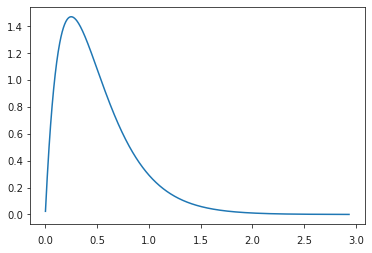

In [107]:
def generate_prior(stan_prior):
    size = 1000
    low, up = 0.00001, 0.9999

    name = stan_prior.split('(')[0]
    param1, param2 = float(stan_prior.split('(')[1].split(',')[0]), float(stan_prior.split('(')[1].split(',')[1][:-1])
    if name=='normal':
        ppf = lambda xx: norm.ppf(xx, loc=param1, scale=param2)
        pdf = lambda xx: norm.pdf(xx, loc=param1, scale=param2)
    elif name=='beta':
        ppf = lambda xx: beta.ppf(xx, a=param1, b=param2)
        pdf = lambda xx: beta.pdf(xx, a=param1, b=param2)
    elif name=='gamma':
        ppf = lambda xx: gamma.ppf(xx, a=param1, scale=1/param2)
        pdf = lambda xx: gamma.pdf(xx, a=param1, scale=1/param2)
    elif name=='uniform': 
        ppf = lambda xx: gamma.ppf(xx, a=param1, scale=param2-param1)
        pdf = lambda xx: gamma.pdf(xx, a=param1, scale=param2-param1)
        
    prior = np.zeros((size, 2))
    prior[:,0] = np.linspace(ppf(low), ppf(up), size)
    prior[:,1] = pdf(prior[:,0])
    
    return prior

pdf = generate_prior('gamma(2,4)')
plt.plot(pdf[:,0], pdf[:,1])
expit(0.5)

# distributions

- Gamma: in BUGS dgamma($\alpha$,$\beta$) is equivalent to $\frac{\beta^{\alpha} \cdot x^{\alpha - 1} e^{-\beta x}}{\Gamma(\alpha)}$. In scipy that's equivalent to `gamma(a=alpha, scale=1/beta)`. $E(X) = \frac{\alpha}{\beta}$

- Beta: $E(X) = \frac{\alpha}{\alpha + \beta}$

# tests

In [128]:
np.log(0.7)

-0.35667494393873245

# pystan

In [ ]:
import pystan

In [ ]:
# Set up the model
n_burnin = 1000
n_samples = 5000
n_chains = 3
n_sims = 1


In [442]:
def create_vax_data(N, se, sp, vax_prob, beta0, beta1):
    x1 = bernoulli.rvs(vax_prob, size=N) # vaccinated (1)/unvaccinated (0)
    X = pd.DataFrame({
        'vax': x1,
        })

    beta_vec = np.array([beta0, beta1])
    X['prob_TD'] = X.apply(lambda row: expit(np.dot(np.array([1, row['vax']]), beta_vec)), axis=1)
    X['test_TD'] = X['prob_TD'].apply(lambda x: bernoulli.rvs(se*x + (1-sp)*(1-x)))
    y = X['test_TD']
    
    dat = dict(
        x1=x1,
        y=y,
        N=N
    )
    return dat

In [443]:
vax_prob = 0.5
N = 1000
beta0, beta1 = 1, np.log(0.7)
beta0_mu, beta0_prec = 0, 0.01
beta1_a, beta1_b = 2, 4
# se_str = jags_distribution('beta',{'a':se_a,'b':se_b})
# sp_str = jags_distribution('beta',{'a':sp_a,'b':sp_b})
se_str = jags_distribution('fixed',{'val': 1})
sp_str = jags_distribution('fixed',{'val': 1})
beta0_str = jags_distribution('norm',{'mu':beta0_mu,'precision':beta0_prec})
beta1_str = jags_distribution('gamma',{'a':beta1_a,'b':beta1_b})

model_code = '\nmodel {{\n# Likelihood\nfor (i in 1:N) {{\ny[i] ~ dbern(se*p[i] + (1-sp)*(1-p[i]))\nlogit(p[i]) <- beta0 + beta1 * x1[i]\n}}\n# Priors\nse{0}\nsp{1}\nbeta0{2}\nbeta1_pos{3}\nbeta1 = -1*beta1_pos\n}}\n'.format(se_str, sp_str, beta0_str, beta1_str)

np.random.seed(23)
dat =  create_vax_data(N, se, sp, vax_prob, beta0, beta1)
model = pj.Model(
    code=model_code,
    data=dat,
    chains=n_chains
)

# Burn-in and thinning
burnin_samples = model.sample(n_burnin, vars=[], thin = 2)

# Post-burn-in and saving results
param_names = ['beta0','beta1','se','sp']
post_samples = model.sample(n_samples,
                           vars=param_names)
idata_jags = az.from_pyjags(post_samples)  

adapting: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 15000 of 15000, elapsed 0:00:05, remaining 0:00:00


In [453]:
print(model_code)


model {
# Likelihood
for (i in 1:N) {
y[i] ~ dbern(se*p[i] + (1-sp)*(1-p[i]))
logit(p[i]) <- beta0 + beta1 * x1[i]
}
# Priors
se=0.9
sp=0.9
beta0~dnorm(0, 0.01)
beta1_pos~dgamma(2, 4)
beta1 = -1*beta1_pos
}



In [454]:
idata_stan = unpickle_object('./stanFit.pkl')

In [452]:
beta0, beta1

(1, -0.35667494393873245)

array([<AxesSubplot:title={'center':'beta0'}>,
       <AxesSubplot:title={'center':'beta1'}>], dtype=object)

array([<AxesSubplot:title={'center':'beta0'}>,
       <AxesSubplot:title={'center':'beta1'}>], dtype=object)

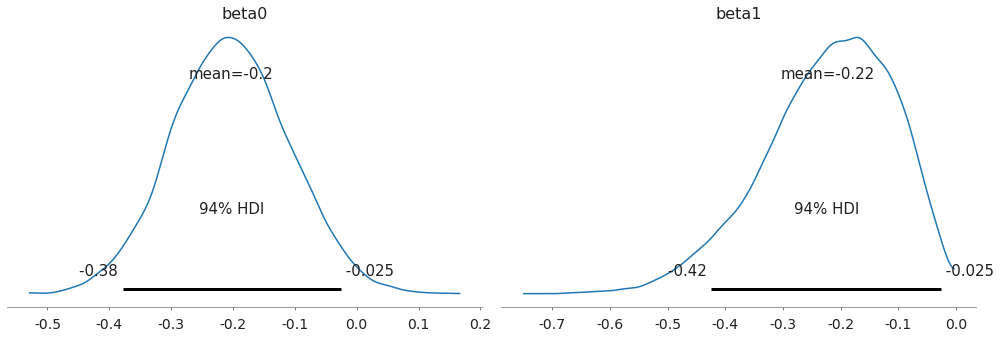

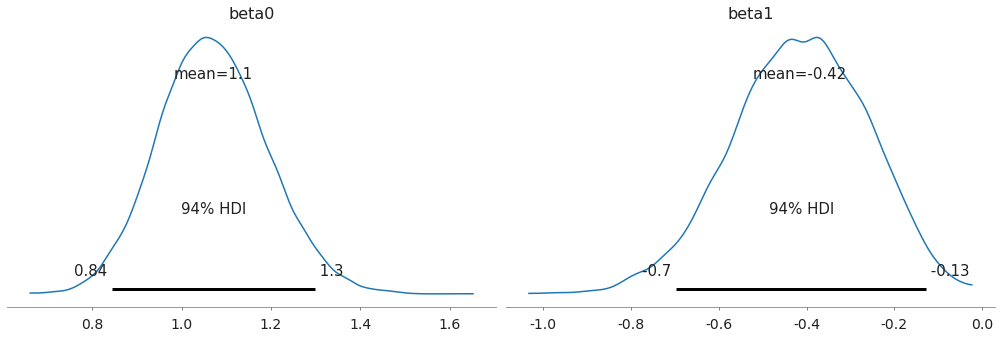

In [455]:
# idata_stan
# idata_jags

az.plot_posterior(idata_jags, var_names=['beta0','beta1'])
az.plot_posterior(idata_stan, var_names=['beta0','beta1'])

In [ ]:
i

In [435]:
stan_code = """
data {
    int<lower=0> N;
    int<lower=0,upper=1> y[N];
    int<lower=0,upper=1> x1[N];
}
transformed data {}
parameters {
    real beta0;
    real<lower=0> beta1;
    // real se;
    // real sp;
}
transformed parameters {
    for(i in 1:N) {
        p[i] = inv_logit(beta0 + beta1*x1[i])
    }
}
model {
    beta0 ~ normal(0,10);
    beta1 ~ normal(0,10);
    for(i in 1:N) {
    
        y[i] ~ bernoulli(se*p[i] + (1-sp)*(1-p[i]));
  }
}
generated quantities {}
"""

fit = pystan.stan(model_code=stan_code, data=dat, warmup=n_burnin, iter=n_samples, chains=n_chains)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_27c5014797c8c8f5027de9cb8feaffc0 NOW.


CompileError: command '/opt/anaconda3/envs/bayes_ve/bin/clang' failed with exit code 254

In [437]:
norm_code = """
data {
    int<lower=0> n;
    real y[n];
}
transformed data {}
parameters {
    real<lower=0, upper=100> mu;
    real<lower=0, upper=10> sigma;
}
transformed parameters {}
model {
    y ~ normal(mu, sigma);
}
generated quantities {}
"""
norm_dat = {
             'n': 100,
             'y': np.random.normal(10, 2, 100),
            }
b
fit = pystan.stan(model_code=norm_code, data=norm_dat, warmup=n_burnin, iter=n_samples, chains=n_chains)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_28da12e8c84b1a8354384170469e2407 NOW.


CompileError: command '/opt/anaconda3/envs/bayes_ve/bin/clang' failed with exit code 254

In [439]:
pystan.StanModel(model_code=norm_code)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_28da12e8c84b1a8354384170469e2407 NOW.


CompileError: command '/opt/anaconda3/envs/bayes_ve/bin/clang' failed with exit code 254

In [ ]:
log_reg_dat = {
             'n': len(df),
             'male': df.male,
             'height': df.height,
             'weight': df.weight
            }

# effect of prior on se & sp

In [ ]:
# Set up the model
n_burnin = 1000
n_samples = 8000
n_chains = 3
vax_prob = 0.5
se_a, se_b = 100, 20
sp_a, sp_b = 100, 20
beta0_mu, beta0_prec = 0, 0.01
beta1_a, beta1_b = 2, 4

np.random.seed(23)
se = beta.rvs(a=se_a, b=se_b)
sp = beta.rvs(a=sp_a, b=sp_b)
beta0 = norm.rvs(loc=beta0_mu, scale=1/np.sqrt(beta0_prec))
beta1 = gamma.rvs(beta1_a, scale=1/beta1_b)
true_vals = {'se': se, 'sp': sp, 'beta0': beta0, 'beta1': beta1}

print(f'### TRUE VALUES (iter={ii})\n{true_vals}')
# simulate data
x1 = bernoulli.rvs(vax_prob, size=N) # vaccinated (1)/unvaccinated (0)
X = pd.DataFrame({
    'vax': x1,
    })
beta_vec = np.array([beta0, beta1])
X['prob_TD'] = X.apply(lambda row: expit(np.dot(np.array([1, row['vax']]), beta_vec)), axis=1)
X['test_TD'] = X['prob_TD'].apply(lambda x: bernoulli.rvs(se*x + (1-sp)*(1-x)))
y = X['test_TD']
dat = dict(
    x1=x1,
    y=y,
    N=N
)

beta0_str = jags_distribution('norm',{'mu':beta0_mu,'precision':beta0_prec})
beta1_str = jags_distribution('gamma',{'a':beta1_a,'b':beta1_b})
se_str = jags_distribution('beta',{'a':se_a,'b':se_b})
sp_str = jags_distribution('beta',{'a':sp_a,'b':sp_b})

model_code_spike = '\nmodel {{\n# Likelihood\nfor (i in 1:N) {{\ny[i] ~ dbern(se*p[i] + (1-sp)*(1-p[i]))\nlogit(p[i]) <- beta0 + beta1 * x1[i]\n}}\n# Priors\nse{0}\nsp{1}\nbeta0{2}\nbeta1_pos{3}\nbeta1 = -1*beta1_pos\n}}\n'.format(se_str, sp_str, beta0_str, beta1_str)
model_spike = pj.Model(
    code=model_code_spike,
    data=dat,
    chains=n_chains
)

se_str = jags_distribution('uni',{'a':0,'b':1})
sp_str = jags_distribution('uni',{'a':0,'b':1})

model_code_uni = '\nmodel {{\n# Likelihood\nfor (i in 1:N) {{\ny[i] ~ dbern(se*p[i] + (1-sp)*(1-p[i]))\nlogit(p[i]) <- beta0 + beta1 * x1[i]\n}}\n# Priors\nse{0}\nsp{1}\nbeta0{2}\nbeta1_pos{3}\nbeta1 = -1*beta1_pos\n}}\n'.format(se_str, sp_str, beta0_str, beta1_str)
model_uni = pj.Model(
    code=model_code_uni,
    data=dat,
    chains=n_chains
)



# Burn-in and thinning
burnin_samples = model.sample(n_burnin, vars=[], thin = 2)

# # Post-burn-in and saving results
param_names = ['beta0','beta1','se','sp']
post_samples = model.sample(n_samples,
                           vars=param_names)
idata = az.from_pyjags(post_samples)
results[N] = idata 



In [ ]:
fig, ax = fig_setup(1,1)

lw = 3
low, up = 0.00001, 0.9999
# NORMAL
# precision = 0.01
# ppf = lambda xx: norm.ppf(xx, loc=0, scale=1/np.sqrt(precision))
# pdf = lambda xx: norm.pdf(xx, loc=0, scale=1/np.sqrt(precision))
# prior = np.zeros((1000,1000))
# prior[:,0] = np.linspace(ppf(low), ppf(up), 1000)
# prior[:,1] = pdf(prior[:,0])
# ax[0].plot(prior[:,0], prior[:,1],
#        '-', lw=lw, alpha=0.6, label=f'normal, mu=0, var={1/precision}')

# GAMMA
# with a and scale = 1/b the pdf is
# f(x,a,b) = b^a x^{a-1} e^{-bx} / Gamma(a)
# 
a, b = 2, 4
ppf = lambda xx: gamma.ppf(xx, a=a, scale=1/b)
pdf = lambda xx: gamma.pdf(xx, a=a, scale=1/b)
prior = np.zeros((1000,1000))
prior[:,0] = np.linspace(ppf(low), ppf(up), 1000)
prior[:,1] = pdf(prior[:,0])
# ax[0].plot(prior[:,0], prior[:,1],'-', lw=lw, alpha=0.6, label='gamma')


# # BETA
# # f(x,a,b) = Gamma(a+b) x^{a-1}(1-x)^{b-1} / (Gamma(a)Gamma(b)) (0<=x<=1, a>0, b>0)
a,b = 100,20
ppf = lambda xx: beta.ppf(xx, a=a, b=b)
pdf = lambda xx: beta.pdf(xx, a=a, b=b)
prior = np.zeros((1000,1000))
prior[:,0] = np.linspace(ppf(low), ppf(up), 1000)
prior[:,1] = pdf(prior[:,0])
ax[0].plot(prior[:,0], prior[:,1],'-', lw=lw, alpha=0.6, label='beta')
ax[0].set_xlim([0,1])
finalize(ax[0])



# Process FIJI data

In [482]:
def plot_centered_error_bars(ax, x, y, true_y, lower, upper, label=None):
    ax.errorbar(x, y-true_y, yerr=(y-lower, upper-y), fmt='.', label=label, ) # error is (lower, upper) = (mean-lower, upper-mean)
    return ax

## consistency fixed se & sp

<AxesSubplot:>

(-2.0, 159.0)

<AxesSubplot:title={'center':'beta0 (proportion of 95% HDIs containing true value = 0.968)'}, xlabel='iteration', ylabel='centered HDI'>

<AxesSubplot:>

(-2.0, 159.0)

<AxesSubplot:title={'center':'beta1 (proportion of 95% HDIs containing true value = 0.924)'}, xlabel='iteration', ylabel='centered HDI'>

dict_keys(['beta0', 'beta1'])

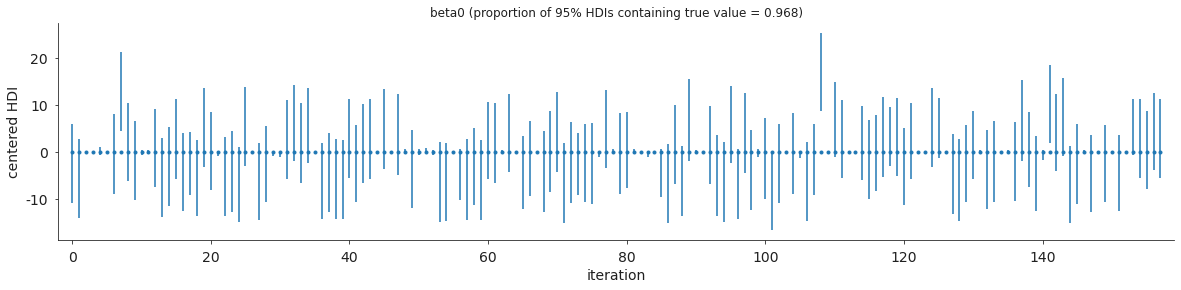

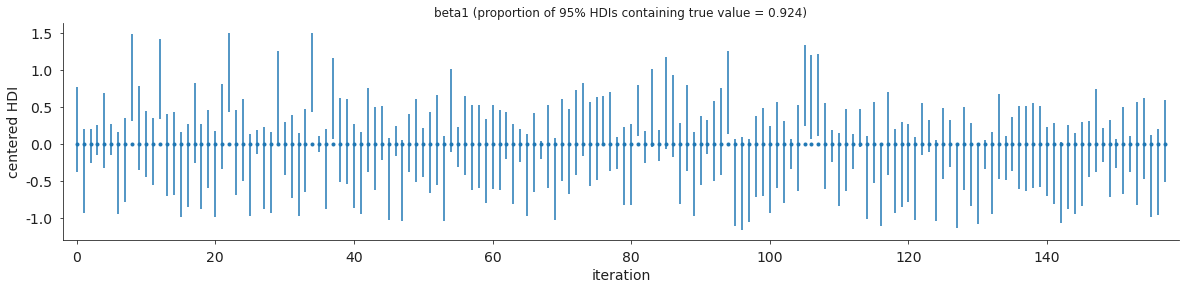

In [508]:
df = unpickle_object('processed_data/consistency_fixed_se_sp_results.pkl')

for param in df.keys():
    data = np.array(df[param])
#     data = data[:3,:]
    # compute proportion of HDIs that contain true param
    prop = np.sum((data[:,0]>=data[:,1]) & (data[:,0]<=data[:,2]))/len(data)

    fig, axs = fig_setup(1,1,w=20)
    x = np.arange(0, len(data)*1,1)
    true = data[:,0]
    lower = data[:,1]
    upper = data[:,2]
    plot_centered_error_bars(axs[0],x,true,true,lower,upper)
    axs[0].set_xlim(x[0]-2,x[-1]+2)
#     set_title_axes_labels(axs[0], r'Consistency for fixed se & sp', 'iteration', 'centered HDI')
    set_title_axes_labels(axs[0], f'{param} (proportion of 95% HDIs containing true value = {prop:.3})', 'iteration', 'centered HDI')
    finalize(axs[0])
    plt.savefig(f'fixed_se_sp_{param}.png',dpi=300)
#     break

## consistency unfixed se & sp

<AxesSubplot:>

(-2.0, 201.0)

<AxesSubplot:title={'center':'beta0 (proportion of 95% HDIs containing true value = 0.875)'}, xlabel='iteration', ylabel='centered HDI'>

<AxesSubplot:>

(-2.0, 201.0)

<AxesSubplot:title={'center':'beta1 (proportion of 95% HDIs containing true value = 0.955)'}, xlabel='iteration', ylabel='centered HDI'>

<AxesSubplot:>

(-2.0, 201.0)

<AxesSubplot:title={'center':'se (proportion of 95% HDIs containing true value = 0.9)'}, xlabel='iteration', ylabel='centered HDI'>

<AxesSubplot:>

(-2.0, 201.0)

<AxesSubplot:title={'center':'sp (proportion of 95% HDIs containing true value = 0.85)'}, xlabel='iteration', ylabel='centered HDI'>

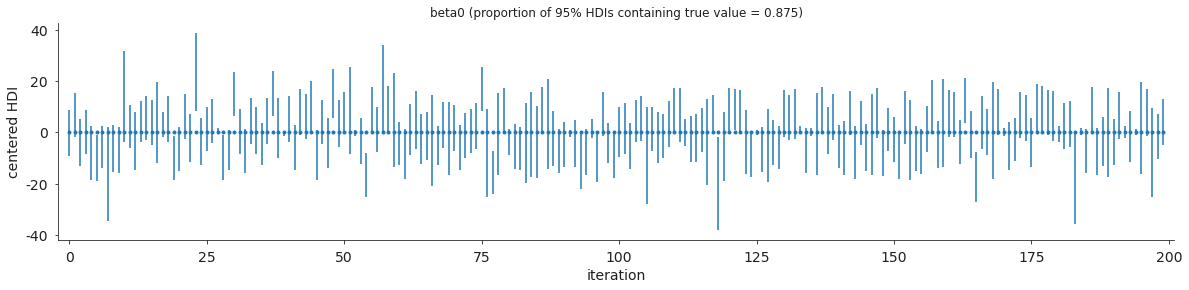

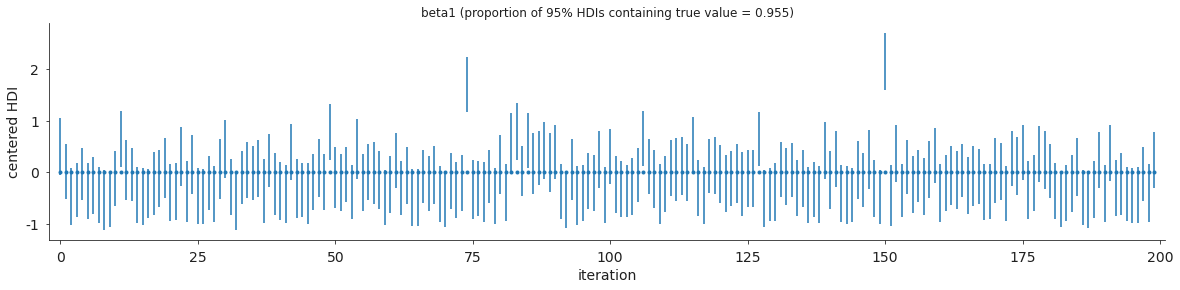

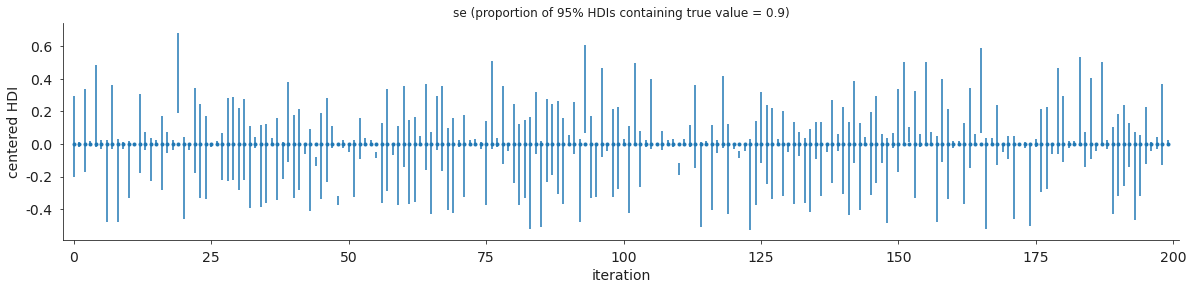

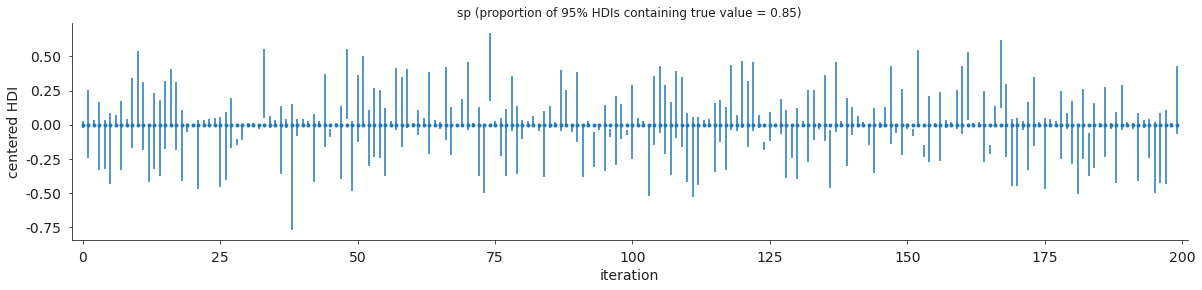

In [529]:
df = unpickle_object('processed_data/consistency_unfixed_se_sp_results.pkl')

for param in df.keys():
    data = np.array(df[param])
#     data = data[:3,:]
    # compute proportion of HDIs that contain true param
    prop = np.sum((data[:,0]>=data[:,1]) & (data[:,0]<=data[:,2]))/len(data)

    fig, axs = fig_setup(1,1,w=20)
    x = np.arange(0, len(data)*1,1)
    true = data[:,0]
    lower = data[:,1]
    upper = data[:,2]
    plot_centered_error_bars(axs[0],x,true,true,lower,upper)
    axs[0].set_xlim(x[0]-2,x[-1]+2)
#     set_title_axes_labels(axs[0], r'Consistency for fixed se & sp', 'iteration', 'centered HDI')
    set_title_axes_labels(axs[0], f'{param} (proportion of 95% HDIs containing true value = {prop:.3})', 'iteration', 'centered HDI')
    finalize(axs[0])
    plt.savefig(f'unfixed_se_sp_{param}.png',dpi=300)
#     break

In [562]:
df = unpickle_object('processed_data/consistency_unfixed_se_sp_results.pkl')
param = 'beta0'
data = np.array(df[param])
data[~((data[:,0]>=data[:,1]) & (data[:,0]<=data[:,2]))]

array([[ 21.2 ,   2.14,  20.37],
       [ -0.58, -18.97,  -2.03],
       [-30.56, -22.26,   8.26],
       [ -1.05, -19.45,  -1.95],
       [-26.57, -20.1 ,  -3.05],
       [-25.47, -18.92,  -1.6 ],
       [  0.69,   1.41,  20.63],
       [ -4.64,   0.95,  20.16],
       [ 28.24,   3.04,  20.1 ],
       [  2.81,   3.11,  20.37],
       [-28.1 , -19.75,  -2.67],
       [ 26.55,   2.56,  19.12],
       [-19.88, -19.63,  -2.02],
       [  3.  , -19.03,   2.47],
       [ 20.7 , -17.49,  18.8 ],
       [  3.24,   3.6 ,  20.46],
       [  2.13,   2.98,  19.2 ],
       [ -1.  , -18.49,  -1.15],
       [ -1.63, -19.68,  -1.89],
       [-21.01, -20.61,  -0.6 ],
       [-24.05, -20.45,  -2.91],
       [  6.09, -20.94,  -1.54],
       [-19.48, -19.3 ,  -0.81],
       [-20.57, -19.91,  -2.43],
       [ 11.94, -23.59,  11.58]])

## sample_size

<AxesSubplot:>

<AxesSubplot:title={'center':'beta0'}, xlabel='sample size', ylabel='centered HDI'>

<AxesSubplot:>

<AxesSubplot:title={'center':'beta1'}, xlabel='sample size', ylabel='centered HDI'>

<AxesSubplot:>

<AxesSubplot:title={'center':'se'}, xlabel='sample size', ylabel='centered HDI'>

<AxesSubplot:>

<AxesSubplot:title={'center':'sp'}, xlabel='sample size', ylabel='centered HDI'>

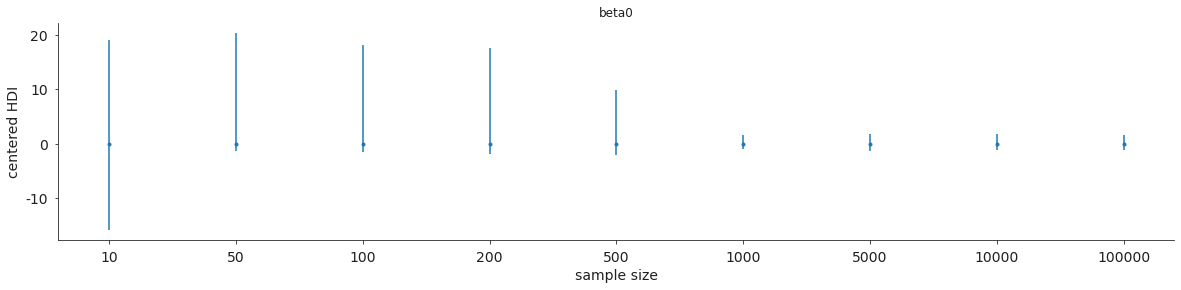

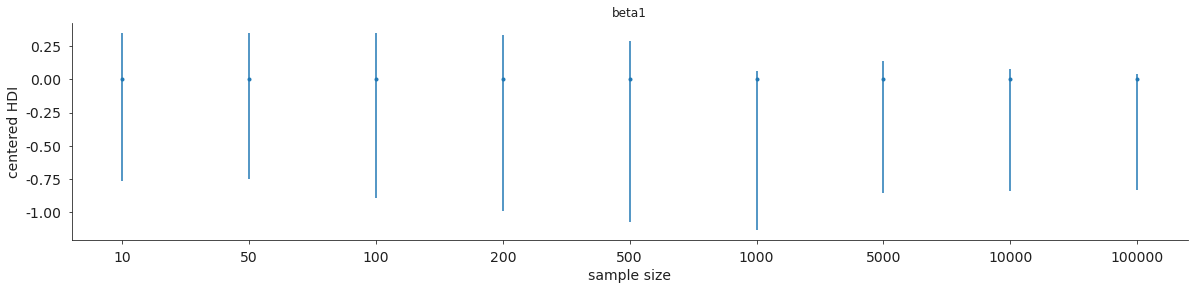

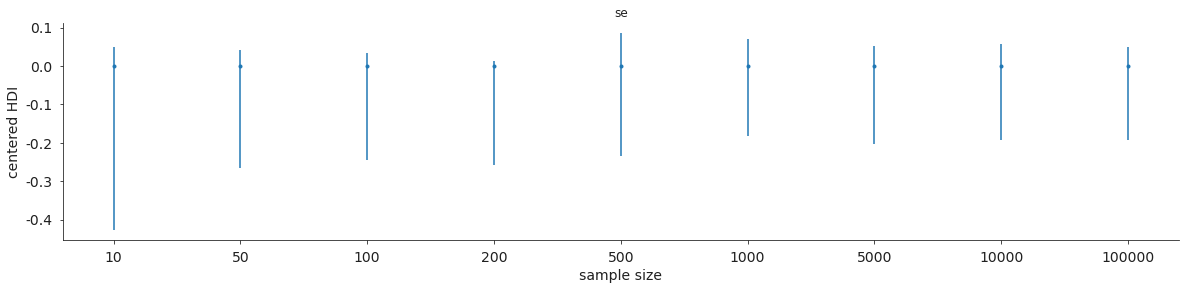

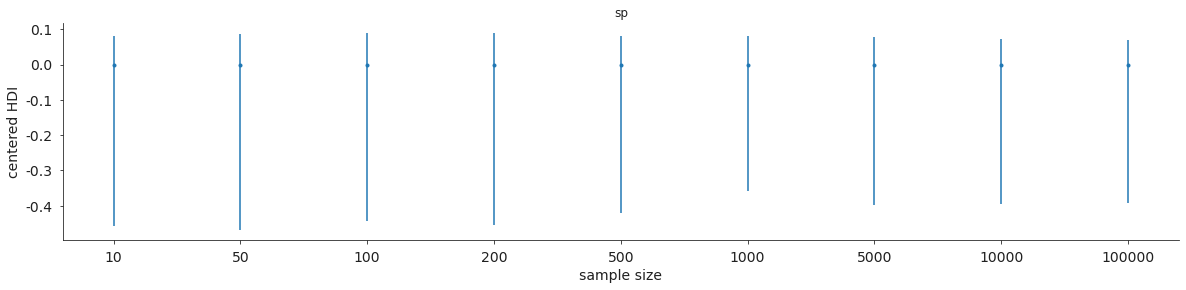

In [530]:
df = unpickle_object('processed_data/sample_size_results.pkl')

for param in df.keys():
    data = np.array(df[param])
    data = data[np.argsort(data[:,0])]
#     data = data[:3,:]

    fig, axs = fig_setup(1,1,w=20)
#     x = data[:,0]
    x = np.arange(0,len(data))
    true = data[:,1]
    lower = data[:,2]
    upper = data[:,3]
    plot_centered_error_bars(axs[0],x,true,true,lower,upper)
#     axs[0].set_xlim(x[0],x[-1]+2)
    tt=axs[0].set_xticks(range(len(data)))
    tt=axs[0].set_xticklabels([int(tmp) for tmp in data[:,0]])
#                               rotation='vertical')

#     set_title_axes_labels(axs[0], r'Consistency for fixed se & sp', 'iteration', 'centered HDI')
    set_title_axes_labels(axs[0], f'{param}', 'sample size', 'centered HDI')
    finalize(axs[0])
    plt.savefig(f'sample_size_{param}.png',dpi=300)
#     break

## 2sample_size

In [4]:
ci_dfs = unpickle_object('./processed_data/2sample_size/ci_dfs.pkl')


NameError: name 'unpickle_object' is not defined

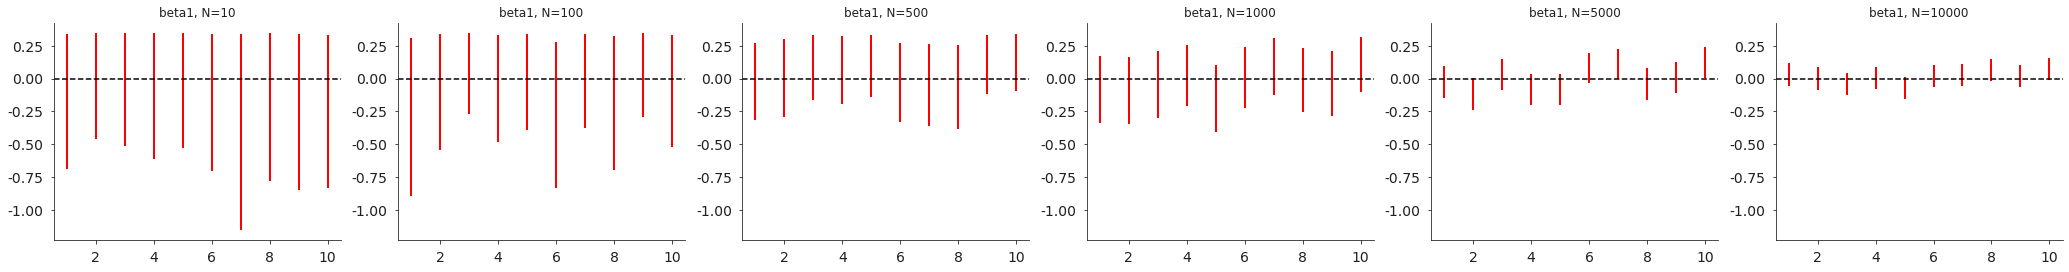

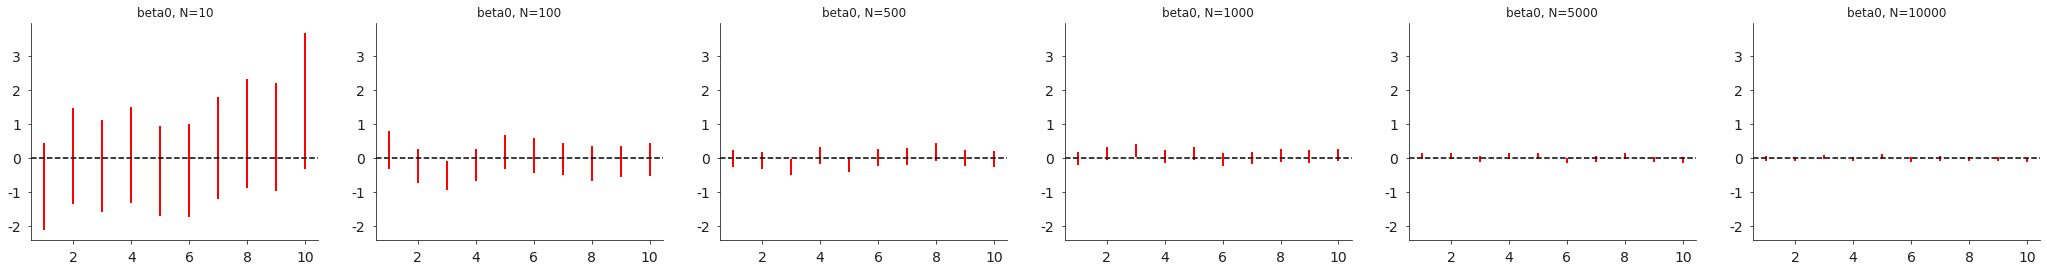

In [24]:
ci_dfs = unpickle_object('./processed_data/2sample_size/ci_dfs.pkl')

param = 'beta1'

fig, axs = fig_setup(1,len(ci_dfs.keys()))
ymin, ymax = 1000, -1000
for ii, N in enumerate(ci_dfs.keys()):
    ci_df = ci_dfs[N][param]
#     ci_df.head(3)
    centered_credible_interval_plot(axs[ii], ci_df)
    tmp_min, tmp_max = axs[ii].get_ylim()
    if ymin>tmp_min: ymin = tmp_min
    if ymax<tmp_max: ymax = tmp_max
    tt=axs[ii].set_title(f'{param}, N={N}')

for ii in range(len(ci_dfs.keys())):
    tt=axs[ii].set_ylim([ymin,ymax])
tt=finalize(axs)
plt.savefig('/Users/erikjohnson/Downloads/tmp1.png',dpi=300)


param = 'beta0'
fig, axs = fig_setup(1,len(ci_dfs.keys()))
ymin, ymax = 1000, -1000
for ii, N in enumerate(ci_dfs.keys()):
    ci_df = ci_dfs[N][param]
#     ci_df.head(3)
    centered_credible_interval_plot(axs[ii], ci_df)
    tmp_min, tmp_max = axs[ii].get_ylim()
    if ymin>tmp_min: ymin = tmp_min
    if ymax<tmp_max: ymax = tmp_max
    tt=axs[ii].set_title(f'{param}, N={N}')

for ii in range(len(ci_dfs.keys())):
    tt=axs[ii].set_ylim([ymin,ymax])
tt=finalize(axs)
plt.savefig('/Users/erikjohnson/Downloads/tmp2.png',dpi=300)
    

# saving stan model

array([<AxesSubplot:title={'center':'beta0'}>,
       <AxesSubplot:title={'center':'beta1_pos'}>,
       <AxesSubplot:title={'center':'beta1'}>], dtype=object)

array([<AxesSubplot:title={'center':'beta0'}>,
       <AxesSubplot:title={'center':'beta1_pos'}>,
       <AxesSubplot:title={'center':'beta1'}>], dtype=object)

,chain,draw,"(posterior, beta0)","(posterior, beta1_pos)","(posterior, beta1)","(sample_stats, accept_stat)","(sample_stats, stepsize)","(sample_stats, treedepth)","(sample_stats, n_leapfrog)","(sample_stats, diverging)","(sample_stats, energy)","(sample_stats, lp)"
0,0,0,0.894004,0.280862,-0.280862,0.993548,0.240029,2,7,False,67.002011,-66.491530
1,0,1,0.821763,0.381338,-0.381338,1.000000,0.240029,2,3,False,66.522773,-66.151785
2,0,2,0.766501,0.483755,-0.483755,0.760660,0.240029,2,3,False,67.168877,-66.273366


,chain,draw,"(posterior, beta0)","(posterior, beta1_pos)","(posterior, beta1)","(sample_stats, accept_stat)","(sample_stats, stepsize)","(sample_stats, treedepth)","(sample_stats, n_leapfrog)","(sample_stats, diverging)","(sample_stats, energy)","(sample_stats, lp)"
0,0,0,0.876966,0.571398,-0.571398,1.000000,0.220133,2,7,False,66.507648,-66.074559
1,0,1,1.025019,0.533098,-0.533098,0.613337,0.220133,2,3,False,68.789386,-66.012480
2,0,2,0.756153,0.530423,-0.530423,0.864902,0.220133,2,3,False,66.673672,-66.395322


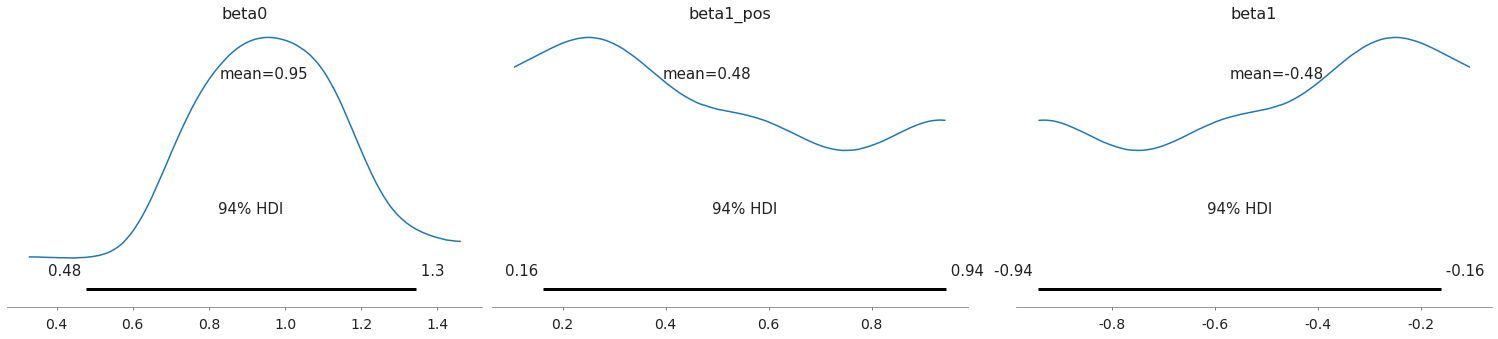

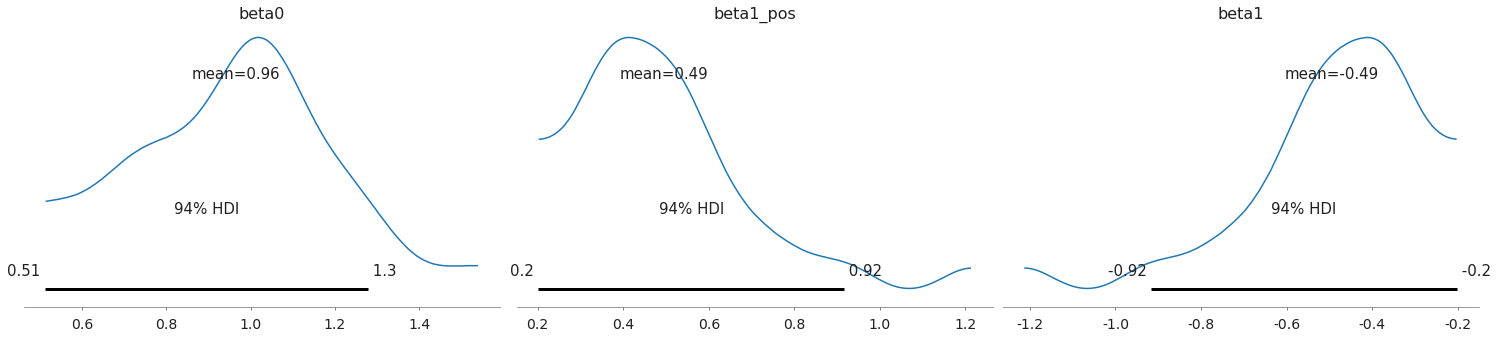

In [64]:
fit = unpickle_object('test_save_stan/fit.pkl')
fit2 = unpickle_object('test_save_stan/fit2.pkl')
ar.plot_posterior(fit)
ar.plot_posterior(fit2)

fit.to_dataframe().head(3)

fit2.to_dataframe().head(3)

In [29]:
ci_dfs

{10: {'beta0':    param  true     lower     upper     width      prob
  0  beta0     1 -1.123790  1.456575  2.580365  0.950067
  1  beta0     1 -0.337399  2.471749  2.809148  0.950067
  2  beta0     1 -0.595719  2.111701  2.707420  0.950067
  3  beta0     1 -0.311440  2.518476  2.829917  0.950067
  4  beta0     1 -0.710413  1.943880  2.654293  0.950067
  5  beta0     1 -0.721714  2.001682  2.723395  0.950067
  6  beta0     1 -0.202516  2.789522  2.992038  0.950067
  7  beta0     1  0.116449  3.332805  3.216356  0.950067
  8  beta0     1  0.025791  3.216639  3.190848  0.950067
  9  beta0     1  0.687853  4.687389  3.999536  0.950067,
  'beta1':    param      true     lower     upper     width      prob
  0  beta1 -0.356675 -1.049399 -0.020668  1.028730  0.950067
  1  beta1 -0.356675 -0.819907 -0.007753  0.812154  0.950067
  2  beta1 -0.356675 -0.870878 -0.011979  0.858899  0.950067
  3  beta1 -0.356675 -0.967742 -0.012251  0.955491  0.950067
  4  beta1 -0.356675 -0.886446 -0.009246  0.8

# effect of prior

In [542]:
results = {'beta0': [], 'beta1': [], 'se': [], 'sp': []}

# beta stan has: beta0 ~ normal(0,10), beta1_pos ~ gamma(2,4), se ~ beta(100,10), sp ~ beta(100,10)
df = unpickle_object('processed_data/beta.pkl')
hdi = ar.hdi(df['idata']).to_dataframe()
for key, val in df['true_params'].items():
    results[key].append(['beta(100,10)', val, hdi[key][0], hdi[key][1]])
    
# beta2 stan has: beta0 ~ normal(0,10), beta1_pos ~ gamma(2,4), se ~ beta(1000,100), sp ~ beta(1000,100)
df = unpickle_object('processed_data/beta2.pkl')
hdi = ar.hdi(df['idata']).to_dataframe()
for key, val in df['true_params'].items():
    results[key].append(['beta(1000,100)', val, hdi[key][0], hdi[key][1]])
    
# uni stan has: beta0 ~ normal(0,10), beta1_pos ~ gamma(2,4), se ~ uniform(0,1), sp ~ uniform(0,1)
df = unpickle_object('processed_data/uniform.pkl')
hdi = ar.hdi(df['idata']).to_dataframe()
for key, val in df['true_params'].items():
    results[key].append(['uni(0,1)', val, hdi[key][0], hdi[key][1]])

results

{'beta0': [['beta(100,10)', 1, 0.720079468618924, 1.3314603645718068],
  ['beta(1000,100)', 1, 0.8149433037371633, 1.1788069681575366],
  ['uni(0,1)', 1, -9.904765756999602, 10.91125304716397]],
 'beta1': [['beta(100,10)',
   -0.35667494393873245,
   -0.5953598862227327,
   -0.1441114749569233],
  ['beta(1000,100)',
   -0.35667494393873245,
   -0.5829817142573074,
   -0.16134475807692816],
  ['uni(0,1)',
   -0.35667494393873245,
   -1.2817327050858147,
   -0.059520013385731006]],
 'se': [['beta(100,10)', 0.9, 0.8546239784687274, 0.9566480281559482],
  ['beta(1000,100)', 0.9, 0.8928318472290948, 0.9253086237652628],
  ['uni(0,1)', 0.9, 0.6418417927916926, 0.9941751728819661]],
 'sp': [['beta(100,10)', 0.9, 0.8563273294200998, 0.9571229464793776],
  ['beta(1000,100)', 0.9, 0.8932051667110471, 0.9253960553893286],
  ['uni(0,1)', 0.9, 0.3283482417690542, 0.9733432094935975]]}

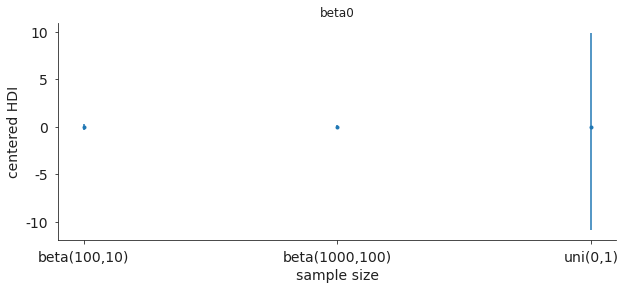

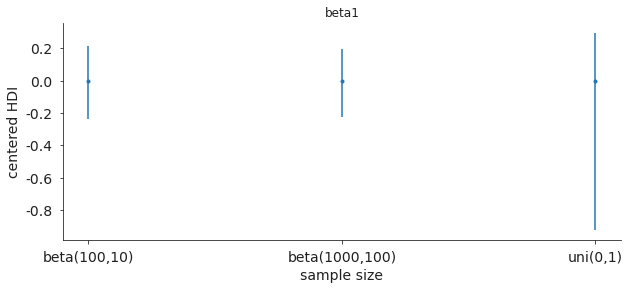

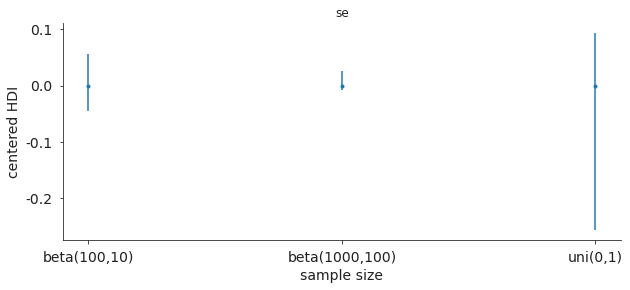

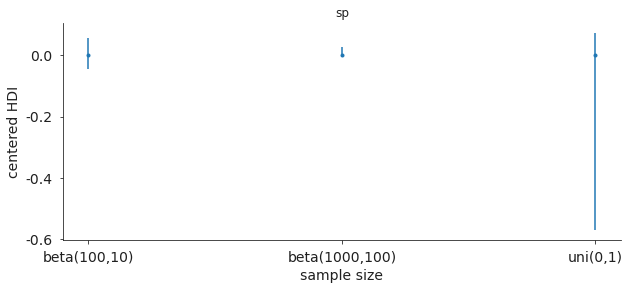

In [555]:
true_params = {'beta0': 1, 'beta1': np.log(0.7), 'se': 0.9, 'sp': 0.9}
for param in results.keys():
#     print(param)
    data = np.array(results[param])
    
    fig, axs = fig_setup(1,1,w=10)
    x = np.arange(0,len(data))
    true = data[:,1].astype(float)
    lower = data[:,2].astype(float)
    upper = data[:,3].astype(float)
    tt=plot_centered_error_bars(axs[0],x,true,true,lower,upper)
#     axs[0].set_xlim(x[0],x[-1]+2)
    tt=axs[0].set_xticks(range(len(data)))
    tt=axs[0].set_xticklabels(data[:,0])
#                               rotation='vertical')

#     set_title_axes_labels(axs[0], r'Consistency for fixed se & sp', 'iteration', 'centered HDI')
    tt=set_title_axes_labels(axs[0], f'{param}', 'sample size', 'centered HDI')
    finalize(axs[0])
    plt.savefig(f'effect_of_prior_{param}.png',dpi=300)
#     break

In [549]:
data[:,1].astype(float)

array([1., 1., 1.])

# posteriors, priors, and CIs

dict_keys(['N', 'n_samples', 'n_burnin', 'vax_prob', 'true_params', 'idata'])

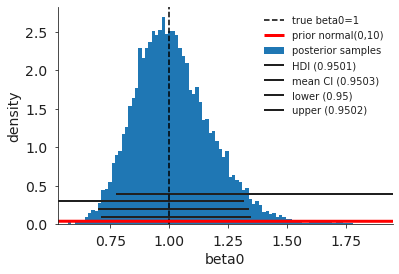

In [801]:
df = unpickle_object('processed_data/beta.pkl')
idata = df['idata']
# ar.plot_posterior(idata, var_names=['beta0'])
# plt.show()
df.keys()

param = 'beta0'
fig, axs = fig_setup(1,1)

# axs[0].hlines(y=1, xmin=interval[1], xmax=interval[1], lw=3, color='red', label='fuck')

# true value as vertical line
tt=axs[0].axvline(x=df['true_params'][param], color='k', linestyle='--',
               label=f"true {param}={df['true_params'][param]}"
              ) #

# prior
x = idata.to_dataframe()[('posterior', f'{param}')]
name = 'normal(0,10)'
prior = generate_prior(name)
val = prior[:,1].max()
tt=axs[0].plot(prior[:,0], prior[:,1], 
               lw=3, 
               color='r', 
               label=f'prior {name}'
              )

# posterior samples
nbins = 100
n, bins, patches =axs[0].hist(x,
                     bins=nbins,
                     density=True,
                     label='posterior samples',
#                      label=f'{param}'
                    )

# credible intervals
# HDI
interval = compute_hdi(idata, 'beta0')
prob = np.sum((x>=interval[0]) & (x<=interval[1]))/len(x)
tt=axs[0].hlines(y=0.1,
                 xmin=interval[0], 
                 xmax=interval[1], 
                 lw=2, 
                 label=f'HDI ({prob:0.4})'
                )

# CI equal-tailed around mean
val = x.mean()
interval, prob = compute_centered_credible_interval(x, val, 0.0005)
tt=axs[0].hlines(y=0.2,
                 xmin=interval[0], 
                 xmax=interval[1], 
                 lw=2, 
                 label=f'mean CI ({prob:0.4})'
                )

# lower CI
interval, prob = compute_lower_credible_interval(x, 0.0005)
tt=axs[0].hlines(y=0.3,
                 xmin=interval[0], 
                 xmax=interval[1], 
                 lw=2, 
                 label=f'lower ({prob:0.4})'
                )

# upper CI
interval, prob = compute_upper_credible_interval(x, 0.0005)
tt=axs[0].hlines(y=0.4,
                 xmin=interval[0], 
                 xmax=interval[1], 
                 lw=2, 
                 label=f'upper ({prob:0.4})'
                )


tt=axs[0].set_xlim(x.min(), x.max())
tt=set_title_axes_labels(axs[0],None,f'{param}','density')
finalize(axs[0])




In [792]:
def compute_hdi(idata, param, prob=0.95):
    hdi = ar.hdi(idata, hdi_prob=prob).to_dataframe()
    interval = [hdi[param][0], hdi[param][1]]
    
    x = idata.to_dataframe()[('posterior', f'{param}')]
    prob = np.sum((x>=interval[0]) & (x<=interval[1]))/len(x)
    return (interval, prob)

def compute_centered_credible_interval(samples, val, step, thresh=0.95):
    prob = 0
    ii = 1
    while prob<thresh:
        interval = [val-ii*step, val+ii*step]
        prob = compute_probability_of_interval(samples, interval)
        ii += 1
    return (interval, prob)

def compute_probability_of_interval(samples, interval):
    samples = samples.sort_values().reset_index(drop=True)
    mask = ((samples>=interval[0]) & (samples<=interval[1]))
    return np.sum(mask)/len(x)

def compute_lower_credible_interval(samples, step, thresh=0.95):
    prob = 0
    ii = 1
    min_val = samples.min()
    while prob<thresh:
        interval = [min_val, val+ii*step]
        prob = compute_probability_of_interval(samples, interval)
        ii += 1
    return (interval, prob)

def compute_upper_credible_interval(samples, step, thresh=0.95):
    prob = 0
    ii = 1
    max_val = samples.max()
    while prob<thresh:
        interval = [val-ii*step, max_val]
        prob = compute_probability_of_interval(samples, interval)
        ii += 1
    return (interval, prob)


(0.720079468618924, 1.3314603645718068)

<AxesSubplot:title={'center':'beta0'}>

([0.688684802010503, 1.3486848020105031], 0.9536666666666667)

([0.6716019905433823, 1.3316019905433825], 0.9510666666666666)

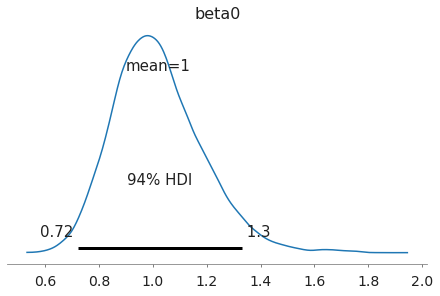

In [739]:
compute_hdi(idata, 'beta0')
ar.plot_posterior(idata, var_names='beta0')
samples = idata.to_dataframe()[('posterior', 'beta0')]
val = samples.mean()
compute_credible_interval_relative_to_value(samples, val,0.01)
val = samples.median()
compute_credible_interval_relative_to_value(samples, val,0.01)


In [ ]:
df = unpickle_object('processed_data/beta.pkl')
idata = df['idata']
# ar.plot_posterior(idata, var_names=['beta0'])
# plt.show()
df.keys()

fig, axs = fig_setup(1,1)

# axs[0].hlines(y=1, xmin=interval[1], xmax=interval[1], lw=3, color='red', label='fuck')

# true value as vertical line
tt=axs[0].axvline(x=df['true_params'][param], color='k', linestyle='--',
               label=f"true {param}={df['true_params'][param]}"
              ) #

tt=axs[0].set_xlim(x.min(), x.max())
tt=set_title_axes_labels(axs[0],None,f'{param}','density')
finalize(axs[0])




,true,lower,upper,prob,width,contains_true
0,0.5,0.2,1.3,0.900,1.1,True
1,1.0,-1.0,5.0,0.955,6.0,True


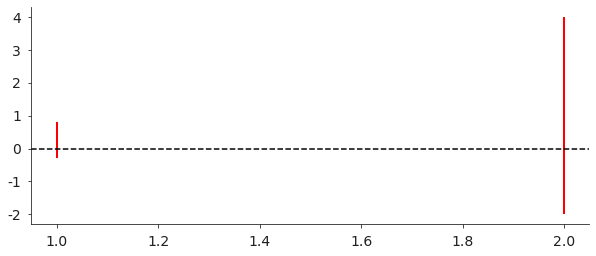

In [903]:
# true = [0.5, 2.4]
# lower = [1.1, 2.3]
# upper = [2, 2.5]
# index = np.arange(1,len(lower)+1)

# plt.show()

# fig, axs = fig_setup(1,1,w=10)
# for ii in range(len(index)):
#     tt=axs[0].vlines(x[ii],
#                   ymin=lower[ii]-true[ii],
#                   ymax=upper[ii]-true[ii],
#                   color='r',
#                   lw=2,
#                   ls='-',
#                   label=f'{ii}'
#                  )
                  
# tt=axs[0].axhline(0,
#                color='k',
#                ls='--'
#               )

def centered_credible_interval_plot(ci_df):
    """
    
    """
#     print(ci_df)
    true, lower, upper = ci_df['true'], ci_df['lower'], ci_df['upper']
#     print(true,lower, upper, ci_df['width'])
    index = np.arange(1,len(lower)+1)
    fig, axs = fig_setup(1,1,w=10)
    for ii in range(len(index)):
        tt=axs[0].vlines(index[ii],
                      ymin=lower[ii]-true[ii],
                      ymax=upper[ii]-true[ii],
                      color='r',
                      lw=2,
                      ls='-',
#                       label=f'{true[ii]}'
                     )
#         tt=axs[0].vlines(index[ii],
#                       ymin=lower[ii],
#                       ymax=upper[ii],
#                       color='r',
#                       lw=2,
#                       ls='-',
# #                       label=f'{ii}'
#                      )


    tt=axs[0].axhline(0,
                   color='k',
                   ls='--'
                  )
    return (fig, axs)

ci_df = pd.DataFrame([[0.5, 0.2, 1.3, 0.9], [1,-1, 5, 0.955]],
                     columns=['true','lower','upper','prob']
                    )
ci_df['width'] = (ci_df['upper']-ci_df['lower'])
ci_df['contains_true'] = ((ci_df['true']>=ci_df['lower']) & (ci_df['true']<=ci_df['upper']))
ci_df

fig, axs = centered_credible_interval_plot(ci_df)
finalize(axs)
# tt=axs[0].set_ylim()
# tt=axs[0].set_xlim()
# tt=set_title_axes_labels(axs[0],param,)


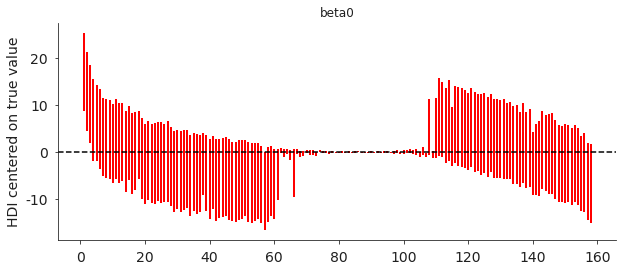

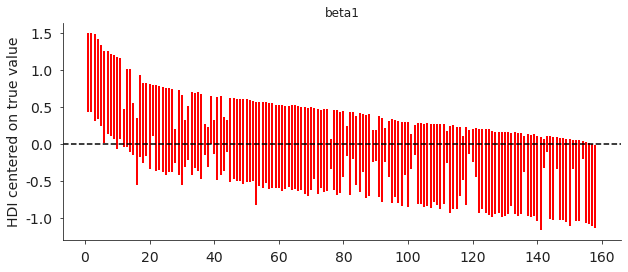

In [913]:
df = unpickle_object('processed_data/consistency_fixed_se_sp_results.pkl')

for param in df.keys():
    ci_df = pd.DataFrame(df[param], columns=['true','lower','upper'])
    ci_df['width'] = (ci_df['upper']-ci_df['lower'])
    ci_df['contains_true'] = ((ci_df['true']>=ci_df['lower']) & (ci_df['true']<=ci_df['upper']))
    ci_df.sort_values('true', inplace=True)
    ci_df.reset_index(drop=True, inplace=True)
    fig, axs = centered_credible_interval_plot(ci_df)
#     plot_centered_error_bars(axs[0],x,true,true,lower,upper)
#     axs[0].set_xlim(x[0]-2,x[-1]+2)
#     set_title_axes_labels(axs[0], f'{param} (proportion of 95% HDIs containing true value = {prop:.3})', 'iteration', 'centered HDI')
    _,_,_ =axs[0].set_title(param), axs[0].set_xlabel(None), axs[0].set_ylabel('HDI centered on true value')
    finalize(axs[0])
#     plt.savefig(f'fixed_se_sp_{param}.png',dpi=300)
#     break
    


In [901]:
ci_df.reset_index?
ci_df

,true,lower,upper,width,contains_true
0,-0.243397,-0.422190,-0.181471,0.240720,True
1,0.561727,0.437788,0.717945,0.280158,True
2,-0.012675,-0.101561,0.187519,0.289080,True
3,0.013159,-0.015838,0.279996,0.295834,True
4,0.271809,0.079694,0.375720,0.296026,True
...,...,...,...,...,...
153,-10.155147,-20.897120,-3.679390,17.217730,True
154,-7.969514,-21.575412,-4.287662,17.287750,True
155,-8.592563,-21.292321,-3.991061,17.301260,True
156,-19.587828,-21.363075,-3.981005,17.382070,True


In [866]:

ci_df

,true,lower,upper,width,contains_true
35,-0.243397,-0.422190,-0.181471,0.240720,True
26,0.561727,0.437788,0.717945,0.280158,True
46,-0.012675,-0.101561,0.187519,0.289080,True
103,0.013159,-0.015838,0.279996,0.295834,True
84,0.271809,0.079694,0.375720,0.296026,True
...,...,...,...,...,...
72,-10.155147,-20.897120,-3.679390,17.217730,True
93,-7.969514,-21.575412,-4.287662,17.287750,True
68,-8.592563,-21.292321,-3.991061,17.301260,True
89,-19.587828,-21.363075,-3.981005,17.382070,True


# notes

Assume CI plots are created from dataframe with columns 'true', 'lower', 'upper', 'width'

In [55]:
np.random.seed(23)
N = 1000
b0 = norm.rvs(loc=0,scale=10, size=N)
a, b = 2, 4
b1 = gamma.rvs(a=a, scale=1/b, size=N)

df = pd.DataFrame([[b0[ii], -b1[ii], 
               b0[ii]-b1[ii], expit(b0[ii]), 
               expit(b0[ii]-b1[ii])] for ii in range(len(b0))],
             columns=['b0','b1','b0+b1','p(b0)','p(b0+b1)'])
df
# df[(df['b0']<=2) & (df['b0']>=0.5)]

,b0,b1,b0+b1,p(b0),p(b0+b1)
0,6.669881,-1.145233,5.524647,0.998733,0.996029
1,0.258131,-0.098612,0.159519,0.564177,0.539795
2,-7.776194,-0.244780,-8.020974,0.000419,0.000328
3,9.486338,-1.416723,8.069615,0.999924,0.999687
4,7.016718,-0.475700,6.541018,0.999104,0.998559
...,...,...,...,...,...
995,-7.849360,-0.676068,-8.525428,0.000390,0.000198
996,-4.823397,-0.237416,-5.060814,0.007975,0.006300
997,9.258867,-0.217739,9.041128,0.999905,0.999882
998,26.121650,-0.128577,25.993073,1.000000,1.000000


In [72]:
np.exp(4)

54.598150033144236